# Introduction

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/matdmiller/blog/blob/main/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/notebook.ipynb)<br>
<br>
In this post we're going to create and optimize GPU CUDA kernels to accelerate an embarrasingly parallel workload and achieve a **8.4 million X** speedup over baseline. Everything you need to create and run CUDA kernels is contained within this blog post which is actually a Jupyter notebook that you can run interactively. This is a fully self contained example workload that can be run for free with no setup required on Google Colab. <br>
<br>
You should run this notebook as you go in Google Colab or any other properly configured CUDA environment. No extra setup is required if you use Google Colab, but if you run in another environment you are responsible for setting it up which is beyond the scope of this post. Learning by doing is more effective than reading alone. Hacking around with the code and seeing how that affects the outcomes helps cement the concepts being taught and builds intuition.<br>
<br>
You will see several methods for computing the workload covered in this post. We will benchmark each method so you observe how quickly they run and begin to build an intuition on much you might be able to accelerate your own workloads. As a rule of thumb you can typically excpect a 10-1,000x speedup when accelerating workloads on GPU's. Each step will be explained and you will learn tips and tricks throughout the post. <br>
<br>
The problem we will be solving is based on a real problem I ran across recently. We had a 3D model with hundreds of thousands of objects. The objects were divided into sets. We needed to figure out which objects from set1 overlapped with objects in set2. Objects in set1 contained metadata which needed to be transferred to all overlapping objects from set2. Each set contained approximately 200,000 objects. Every object from set1 needed to be checked for overlap against every object in set2 which equated to 200,000 * 200,000 = 40 Billon checks that needed to be completed. We had the min and max x,y,z bounding box coordinates for every object which is what we used to check for overlap. When the problem was brought to me an initial attempt was made to solve it by looping through each set of objects in pandas and checking for overlapping objects. The problem was this approach was going to take almost a month to run. This was a perfect embarassingly parallel workload and happened to perfectly coincide with the [CUDA MODE](https://github.com/cuda-mode/lectures) class I was taking. It was the perfect opportunity to implement my newly learned CUDA skills on real world problem. Code is included in this notebook to create a synthetic dataset that matches this problem.<br>
<br>
We will follow the same path I took when trying out different methods to solve this problem. We'll start out with the basic pandas for loop code that was brought to me initially and I'll show you a simple trick to speed up pandas for loops. Next we'll look at a solution using numpy and broadcasting. This is one of the simplest ways to parallelize workloads on CPU's. This reduced the runtime from 777 hours with our initial pandas for loop to 8 minutes. From a practical perspective this was an acceptable amount of time to wait for the answer, but I was curious how much faster I could make this a custom CUDA kernel. The results were surprising to say the least. The next easy step was to take the numpy broadcasting solution and conver it to pytorch and run it on the GPU. This brought the runtime down to 15 seconds, a 32x improvement. At this point I was skeptical how much better a custom CUDA kernel would really be able to speed this up. After all pytorch is an incredibly optimized library for performing AI training, would I really be able to beat it. It turns out the answer was yes! Not that my CUDA code is better than pytorch's, it's definitely not, however my code that was written for this specific problem ended up being a lot faster than the broadcasting solution in pytorch. I'll show you how to write and run C++ CPU and CUDA code using the pytorch `load_inline` compiler solution. I'll also show you how create compiled CPU and CUDA solutions using numba and compare and contrast the 2 options and explain why I like numba better.<br>
<br>
A special thanks to [Mark Saroufim](https://twitter.com/marksaroufim) and [Andreas Köpf](https://twitter.com/neurosp1ke) for creating the [CUDA MODE lecture series](https://www.youtube.com/@CUDAMODE) and [Jeremy Howard](https://twitter.com/jeremyphoward) for beautifully demonstrating 2 dead simple ways to get started with CUDA programming using PyTorch `load_inline` and Numba. <br>

*   PyTorch `load_inline` [lecture](https://youtu.be/4sgKnKbR-WE) and [notebook](https://github.com/cuda-mode/lectures/blob/main/lecture_003/pmpp.ipynb)
*   Numba [lecture](https://youtu.be/wVsR-YhaHlM?si=YiYq154tjebPdOZ5) and [notebook](https://github.com/cuda-mode/lectures/blob/main/lecture_005/matmul_l5.ipynb)

Before we jump into the code I'll show you the benchmarking results to hopefully get you excited about the speedups you're going to learn how to implement.

In [ ]:
#|code-fold: true
#Compiled benchmark results:

#    task,                              gpu,       duration, uom,
data = [
    ('pandas_iterrows',                 't4_2',    777,      'h'),
    ('pandas_itertuples',               't4_2',    15,       'h'),
    ('numpy_cpu_broadcasting',          't4_2',    7.87,     'm'),
    ('torch_gpu_broadcasting',          't4_2',    0.25,     'm'),
    ('cpp_gpu_tli',                     't4_2',    369,      'ms'),
    ('cpp_cpu_1_thread_tli',            't4_2',    3.78,     'm'),
    ('cpp_cpu_omp_tli',                 't4_2',    2.25,     'm'),
    ('numba_cpu_f32',                   't4_2',    1.17,     'm'),
    ('numba_cpu_i32',                   't4_2',    1.02,     'm'),
    ('numba_gpu_0',                     't4_2',    401,      'ms'),
    ('numba_gpu_smem1_f32',             't4_2',    345,      'ms'),
    ('numba_gpu_smem2_f32',             't4_2',    333,      'ms'),
    ('numba_gpu_smem3_f16',             't4_2',    331,      'ms'),

    ('pandas_iterrows',                 'a100_12', 427,      'h'),
    ('pandas_itertuples',               'a100_12', 12.2,     'h'),
    ('numpy_cpu_broadcasting',          'a100_12', 6.28,     'm'),
    ('torch_gpu_broadcasting',          'a100_12', 0.053,    'm'),
    ('cpp_gpu_tli',                     'a100_12', 85,       'ms'),
    ('cpp_cpu_1_thread_tli',            'a100_12', 1.8,      'm'),
    ('cpp_cpu_omp_tli',                 'a100_12', 1.2,      'm'),
    ('numba_cpu_f32',                   'a100_12', 0.17,     'm'),
    ('numba_cpu_i32',                   'a100_12', 0.16,     'm'),
    ('numba_gpu_0',                     'a100_12', 122,      'ms'),
    ('numba_gpu_smem1_f32',             'a100_12', 114,      'ms'),
    ('numba_gpu_smem2_f32',             'a100_12', 115,      'ms'),
    ('numba_gpu_smem3_f16',             'a100_12', 110,      'ms'),
]

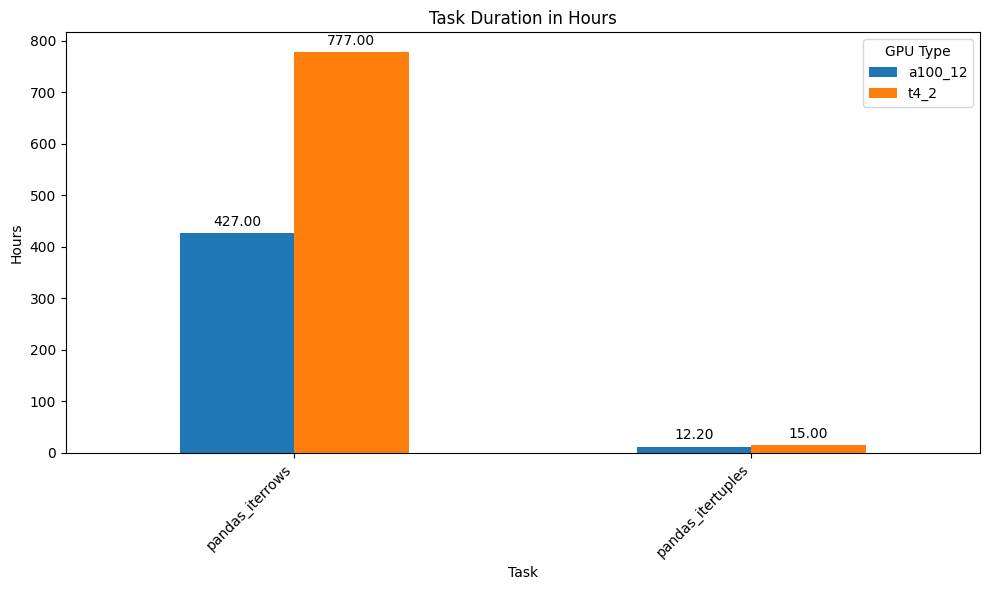

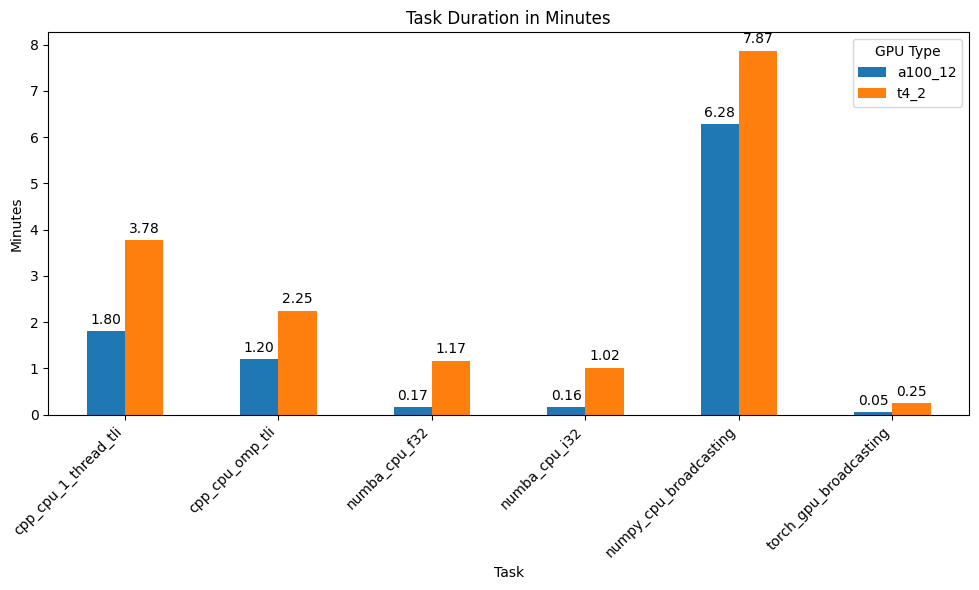

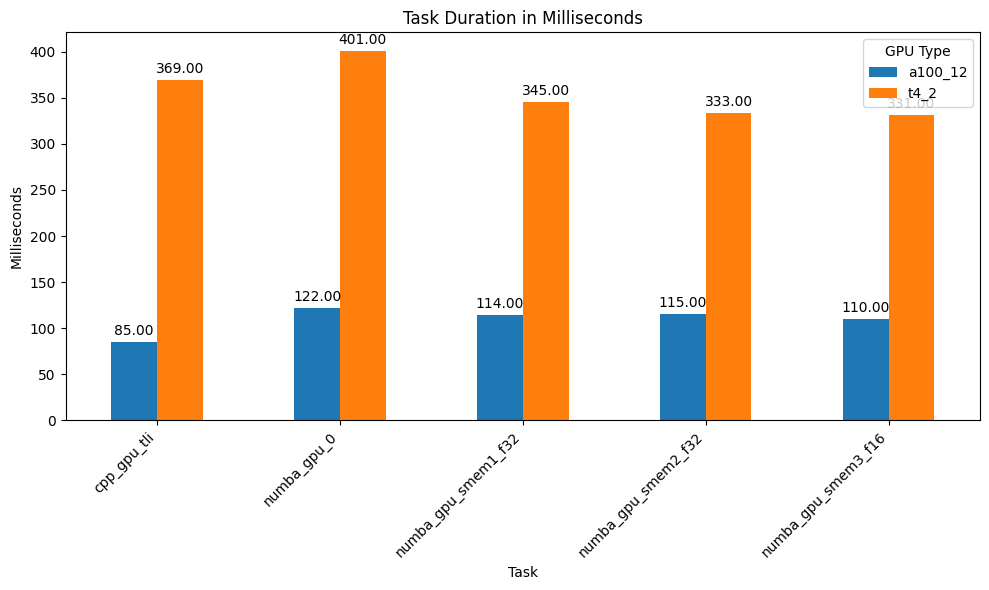

In [ ]:
#|echo: false
# Code to plot the benchmarks

import pandas as pd
import matplotlib.pyplot as plt

columns = ['task', 'gpu', 'duration', 'uom']
df = pd.DataFrame(data, columns=columns)

# Function to plot runtimes with properly separated bars for each GPU type
def plot_runtime(df, title, y_label):
    fig, ax = plt.subplots(figsize=(10, 6))
    # Create a bar plot with proper separation
    df.pivot(index='task', columns='gpu', values='duration').plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Task')
    ax.set_ylabel(y_label)
    # Annotate each bar with duration values
    for bar in ax.containers:
        ax.bar_label(bar, fmt='%.2f', label_type='edge', padding=3)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='GPU Type')
    plt.tight_layout()
    plt.show()

# Generate plots for each unit of measure
plot_runtime(df[df['uom'] == 'h'], 'Task Duration in Hours', 'Hours')
plot_runtime(df[df['uom'] == 'm'], 'Task Duration in Minutes', 'Minutes')
plot_runtime(df[df['uom'] == 'ms'], 'Task Duration in Milliseconds', 'Milliseconds')


As you can see our runtime went from hours to minutes to milliseconds as we added first CPU and then GPU acceleration. Keep on reading to see the implementations of each implementation.

# Environment Setup

## Colab Setup

Getting started in Google Colab is fortunately very easy! Just load this notebook in Google Colab and select a GPU enabled runtime. A free Nvidia T4 instance will work just fine, though it's a bit slow. All of the base benchmarks in this notebook were obtained using a free T4 instance on Colab.<br>
<br>
As of May 2024 Colab comes with all of the required dependencies such as CUDA, pytorch, numpy, pandas, numba, tqdm, ipywidgets, etc except for Ninja and wurlitzer which you can install by running the command below.

In [ ]:
!pip install Ninja wurlitzer

## Local Setup (Not Recommended for Beginners)

These are the steps I followed to set up my environment for this project. They are not comprehensive and may not be optimal for your situation. You may use them as a reference but please modify them as necessary to fit your situation. If you get stuck, I suggest using Google Colab instead of trying to run this locally because it is easier to get started with.

- Setup new conda environment: `conda create -n numba python=3.9`
- Activate your new environment: `conda activate numba`
- `pip install -U setuptools pip ninja`
- `conda install -c conda-forge cupy cuda-version=12.1`
- `conda install nvidia::cuda-python`
- `conda install nvidia/label/cuda-12.1.0::cuda`
- Install conda prereqs: `conda install numba`
- Install pytorch: `conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia`
- Install pip pre-reqs: `pip install pandas tqdm ipywidgets wurlitzer`
- (Optional) Setup the conda env as a jupyter kernel: `conda install ipykernel` and `ipython kernel install --user --name=numba`

# Generate a Synthetic Dataset

First we'll start off by creating a synthetic dataset of 200,000 (pipe) segments and 200,000 (weld) itersections which will generate 40,000,000,000 (40 Billion) checks to be done. This dataset is similar to the original dataset of 3D model object bounding boxes that we needed find ones that were overlapping.

In [ ]:
import numpy as np
import random
import pandas as pd

In [ ]:
%%time
## set random seeds so your randomly generated dataset should be the same as mine
random.seed(42)
np.random.seed(42)
num_segments = 200_000 #total (pipe) segments
chain_length = 20 #number of segments in a sequence before resetting with a new starting point.
x_min, y_min, z_min = 200*1_000, 200*1_000, 200*1_000 #min values for chain starting point
x_max, y_max, z_max = 400*1_000, 400*1_000, 250*1_000 #max values for chain starting point
segments = []
intersections = []
for i in range(num_segments//chain_length):
    #chain starting point
    xi, yi, zi = random.randint(x_min, x_max), random.randint(y_min, y_max), random.randint(z_min, z_max)
    for j in range(chain_length):
        d = random.randint(0,2) #direction in positive x, y, or z
        l = random.randint(1_000,9_000) #length of segment
        xj, yj, zj = xi+l*(d==0), yi+l*(d==1), zi+l*(d==2) # coordinates of end of segment
        xo, yo, zo = 75*(1-(d==0)), 75*(1-(d==1)), 75*(1-(d==2)) # offsets for bounding boxes
        segments.append((i,j,d,l,xi-xo,yi-yo,zi-zo,xj+xo,yj+yo,zj+zo))
        intersections.append((i,j,d,l,xi-80,yi-80,zi-80,xi+80,yi+80,zi+80))
        xi, yi, zi = xj, yj, zj #set end of this segment as the beginning of the next segment
print(f"{len(segments):,} (segments) x {len(intersections):,} (intersections)")
segments[:3],intersections[:3]

200,000 (segments) x 200,000 (intersections)
CPU times: user 892 ms, sys: 79.9 ms, total: 971 ms
Wall time: 1.08 s


([(0, 0, 2, 3253, 367546, 229109, 201639, 367696, 229259, 204892),
  (0, 1, 0, 2828, 367621, 229109, 204817, 370449, 229259, 204967),
  (0, 2, 0, 7033, 370449, 229109, 204817, 377482, 229259, 204967)],
 [(0, 0, 2, 3253, 367541, 229104, 201559, 367701, 229264, 201719),
  (0, 1, 0, 2828, 367541, 229104, 204812, 367701, 229264, 204972),
  (0, 2, 0, 7033, 370369, 229104, 204812, 370529, 229264, 204972)])

In [ ]:
#verify bounding box dims: direction, length, x, y , z
t=segments
t[0][2],t[0][3],t[0][7]-t[0][4],t[0][8]-t[0][5],t[0][9]-t[0][6]

(2, 3253, 150, 150, 3253)

This should be: `(2, 3253, 150, 150, 3253)`

In [ ]:
df_intersections = pd.DataFrame(intersections, columns=["chain_idx","chain_item_idx","direction","length",
                                     "minX","minY","minZ","maxX","maxY","maxZ"])
df_intersections

,chain_idx,chain_item_idx,direction,length,minX,minY,minZ,maxX,maxY,maxZ
0,0,0,2,3253,367541,229104,201559,367701,229264,201719
1,0,1,0,2828,367541,229104,204812,367701,229264,204972
2,0,2,0,7033,370369,229104,204812,370529,229264,204972
3,0,3,0,6543,377402,229104,204812,377562,229264,204972
4,0,4,2,8308,383945,229104,204812,384105,229264,204972
...,...,...,...,...,...,...,...,...,...,...
199995,9999,15,1,6831,348400,295220,229795,348560,295380,229955
199996,9999,16,1,4785,348400,302051,229795,348560,302211,229955
199997,9999,17,2,1271,348400,306836,229795,348560,306996,229955
199998,9999,18,2,8321,348400,306836,231066,348560,306996,231226


In [ ]:
df_segments = pd.DataFrame(segments, columns=["chain_idx","chain_item_idx","direction","length",
                                     "minX","minY","minZ","maxX","maxY","maxZ"])
df_segments

,chain_idx,chain_item_idx,direction,length,minX,minY,minZ,maxX,maxY,maxZ
0,0,0,2,3253,367546,229109,201639,367696,229259,204892
1,0,1,0,2828,367621,229109,204817,370449,229259,204967
2,0,2,0,7033,370449,229109,204817,377482,229259,204967
3,0,3,0,6543,377482,229109,204817,384025,229259,204967
4,0,4,2,8308,383950,229109,204892,384100,229259,213200
...,...,...,...,...,...,...,...,...,...,...
199995,9999,15,1,6831,348405,295300,229800,348555,302131,229950
199996,9999,16,1,4785,348405,302131,229800,348555,306916,229950
199997,9999,17,2,1271,348405,306841,229875,348555,306991,231146
199998,9999,18,2,8321,348405,306841,231146,348555,306991,239467


### Shuffle the dataset (Optional)

If you want to make this 'harder' you can shuffle the dataset. A shuffled dataset would be more representative of the original dataset I had, but since we are checking every object from set 1 vs every object from set 2 it doesn't make a difference performance wise. Also by leaving the dataset sorted as-is, it's easier to inspect the results to see if it's working correctly.

In [ ]:
# shuffle the rows
# df_intersections = df_intersections.sample(frac = 1)
# df_intersections

The last row of shuffled df should be: `121958	6097	18	0	4895	289765	259562	276875	289925	259722	277035`

In [ ]:
# shuffle the rows
# df_segments = df_segments.sample(frac = 1)
# df_segments

The last row of shuffled df should be: `68680	3434	0	0	6708	399431	242270	218081	406139	242420	218231`

### Save the Dataset

In [ ]:
## save our synthetic data to be processed
df_intersections.to_csv('./set1.csv.zip',compression={'method': 'zip'},index=False)
df_segments.to_csv('./set2.csv.zip',compression={'method': 'zip'},index=False)

# Imports

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import os
import math

import torch
from torch.utils.cpp_extension import load_inline

from numba import jit, njit, prange
from numba import cuda
from numba.cuda import as_cuda_array as ca
from numba import int32, float32, int64

One of the exciting aspects of writing CUDA kernels is observing the performance improvements. These improvements can vary significantly across different hardware configurations. Below, we extract the runtime hardware information to tag our benchmark results. This tagging is crucial as it provides context about the hardware used, helping you develop a mental model and build intuition about the potential speedups achievable with the various techniques demonstrated.

In [ ]:
# Get the hardware runtime information
try:
  cpu_type = !cat /proc/cpuinfo | grep 'model name' | uniq
  cpu_type = cpu_type[0].split(':')[1].strip()
except:
  cpu_type = 'Undefined CPU Type'
try:
  cpu_cores = os.cpu_count()
except:
  cpu_cores = 0
try:
  gpu_name = torch.cuda.get_device_name(torch.cuda.current_device())
except:
  gpu_name = 'Undefined GPU Name'
try:
  is_colab = 'Google Colab' if 'COLAB_RELEASE_TAG' in os.environ else 'Other'
except:
  is_colab = 'Other'
print(cpu_type, cpu_cores, gpu_name, is_colab)
hardware_runtime_info = f"Hardware Runtime - CPU: {cpu_cores} Core {cpu_type}, GPU: {gpu_name}, Runtime Location: {is_colab}"
print(hardware_runtime_info)

Intel(R) Xeon(R) CPU @ 2.00GHz 2 Tesla T4 Google Colab
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


# Loading the data

To start off we'll load the data from 2 files containing sets of bounding box coordinates, representing pipes and welds, that we want to check for overlaps between each set.

In [ ]:
import pandas as pd

In [ ]:
#Uncomment the following lines to download the custom dataset
# !wget https://github.com/matdmiller/blog/blob/main/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/set1.csv.zip
# !wget https://github.com/matdmiller/blog/blob/main/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/set2.csv.zip

First we'll load set1 which represents the welds or intersections between pipe segments.

In [ ]:
df_set1 = pd.read_csv('./set1.csv.zip',compression={'method': 'zip'})
print(f"{len(df_set1):,}")
df_set1.head(3)

200,000


,chain_idx,chain_item_idx,direction,length,minX,minY,minZ,maxX,maxY,maxZ
0,0,0,2,3253,367541,229104,201559,367701,229264,201719
1,0,1,0,2828,367541,229104,204812,367701,229264,204972
2,0,2,0,7033,370369,229104,204812,370529,229264,204972


In [ ]:
# verify the size of the weld (intersection) objects in set 1 are all uniform
(
    ((df_set1["minX"]-df_set1["maxX"]) == -160).all(),
    ((df_set1["minY"]-df_set1["maxY"]) == -160).all(),
    ((df_set1["minZ"]-df_set1["maxZ"]) == -160).all()
)

(True, True, True)

Now we'll load set2 which represents the pipe or segments.

In [ ]:
df_set2 = pd.read_csv('./set2.csv.zip',compression={'method': 'zip'})
print(f"{len(df_set2):,}")
df_set2.head(3)

200,000


,chain_idx,chain_item_idx,direction,length,minX,minY,minZ,maxX,maxY,maxZ
0,0,0,2,3253,367546,229109,201639,367696,229259,204892
1,0,1,0,2828,367621,229109,204817,370449,229259,204967
2,0,2,0,7033,370449,229109,204817,377482,229259,204967


In [ ]:
(
    df_set2.iloc[0].maxX-df_set2.iloc[0].minX,
    df_set2.iloc[0].maxY-df_set2.iloc[0].minY,
    df_set2.iloc[0].maxZ-df_set2.iloc[0].minZ,
    df_set2.iloc[0].direction,
    df_set2.iloc[0].length
)
#(150, 150, 3253, 2, 3253)

(150, 150, 3253, 2, 3253)

Now we'll create numpy arrays and torch tensors which we'll use later on.

In [ ]:
set1_np = df_set1[['minX', 'minY', 'minZ', 'maxX', 'maxY', 'maxZ']].to_numpy()
set2_np = df_set2[['minX', 'minY', 'minZ', 'maxX', 'maxY', 'maxZ']].to_numpy()
set1_np, set2_np

(array([[367541, 229104, 201559, 367701, 229264, 201719],
        [367541, 229104, 204812, 367701, 229264, 204972],
        [370369, 229104, 204812, 370529, 229264, 204972],
        ...,
        [348400, 306836, 229795, 348560, 306996, 229955],
        [348400, 306836, 231066, 348560, 306996, 231226],
        [348400, 306836, 239387, 348560, 306996, 239547]]),
 array([[367546, 229109, 201639, 367696, 229259, 204892],
        [367621, 229109, 204817, 370449, 229259, 204967],
        [370449, 229109, 204817, 377482, 229259, 204967],
        ...,
        [348405, 306841, 229875, 348555, 306991, 231146],
        [348405, 306841, 231146, 348555, 306991, 239467],
        [348405, 306841, 239467, 348555, 306991, 241680]]))

In [ ]:
set1_tt = torch.tensor(set1_np/1000,dtype=torch.float32).contiguous().cuda()
set2_tt = torch.tensor(set2_np/1000,dtype=torch.float32).contiguous().cuda()
set1_tt, set2_tt

(tensor([[367.5410, 229.1040, 201.5590, 367.7010, 229.2640, 201.7190],
         [367.5410, 229.1040, 204.8120, 367.7010, 229.2640, 204.9720],
         [370.3690, 229.1040, 204.8120, 370.5290, 229.2640, 204.9720],
         ...,
         [348.4000, 306.8360, 229.7950, 348.5600, 306.9960, 229.9550],
         [348.4000, 306.8360, 231.0660, 348.5600, 306.9960, 231.2260],
         [348.4000, 306.8360, 239.3870, 348.5600, 306.9960, 239.5470]],
        device='cuda:0'),
 tensor([[367.5460, 229.1090, 201.6390, 367.6960, 229.2590, 204.8920],
         [367.6210, 229.1090, 204.8170, 370.4490, 229.2590, 204.9670],
         [370.4490, 229.1090, 204.8170, 377.4820, 229.2590, 204.9670],
         ...,
         [348.4050, 306.8410, 229.8750, 348.5550, 306.9910, 231.1460],
         [348.4050, 306.8410, 231.1460, 348.5550, 306.9910, 239.4670],
         [348.4050, 306.8410, 239.4670, 348.5550, 306.9910, 241.6800]],
        device='cuda:0'))

In [ ]:
set_size = len(df_set1)
assert set_size == len(df_set2), 'set sizes do not match which throws off the performance calcs in some cases but should not affect the results'
total_comparisons = set_size * set_size
print(f"set_size: {set_size:,}")
print(f"total_comparisons: {total_comparisons:,}")

set_size: 200,000
total_comparisons: 40,000,000,000


# A naive python approach using Pandas

First, we begin with a naive Python pandas for loop. This approach will confirm our logic and serve as a benchmark to measure the speedup achieved with CUDA. Spoiler alert: the improvement is significant!<br>
<br>
Due to the inefficiency of pandas for loops, we'll work with a small subset of the data to ensure the code runs in a reasonable amount of time.

In [ ]:
def check_overlap(obj1:list, obj2:list) -> bool:
    return obj1[0] <= obj2[3] and obj1[1] <= obj2[4] and obj1[2] <= obj2[5] and \
        obj1[3] >= obj2[0] and obj1[4] >= obj2[1] and obj1[5] >= obj2[2]

To start off we'll check the first 2 objects from set 1 against set 2.

In [ ]:
%%time
print(hardware_runtime_info)
#Check the first 2 objects of set1 against all items in set2.
overlapping_pairs = list()
for idx1,obj1 in tqdm(df_set1[['minX', 'minY', 'minZ', 'maxX', 'maxY', 'maxZ']].iloc[1:3].iterrows()):
    for idx2,obj2 in tqdm(df_set2[['minX', 'minY', 'minZ', 'maxX', 'maxY', 'maxZ']].iterrows()):
        if check_overlap(obj1,obj2):
            overlapping_pairs.append((idx1,idx2))
print(len(overlapping_pairs))
overlapping_pairs

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

4
CPU times: user 17.3 s, sys: 142 ms, total: 17.4 s
Wall time: 21.4 s


[(1, 0), (1, 1), (2, 1), (2, 2)]

You'll notice that I've included the results of running code blocks as static text within the notebook, in addition to the Jupyter cell output. This ensures you can always see the results I obtained, even if the cell output is cleared. Additionally, I've included results from running the code on different GPU instance types to illustrate the performance variations across different hardware.<br>
<br>
Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 20.9 s, sys: 114 ms, total: 21 s
Wall time: 27.9 s
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 15.4 s, sys: 69.6 ms, total: 15.5 s
Wall time: 15.4 s
----------------------------------------------------------------------------------------------------
```

Checking just 2 * 200,000 = 400,000 of the total required 40,000,000,000 (40 billion) checks, or just 0.001% of the data, took 28 seconds on `Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab`. Extrapolating this to the full dataset, it would take 777 hours or 32 days to complete. We can do better.

In [ ]:
#|echo: false
dur_sec_pandas_iterrows = 28 / (2 * 200_000/40_000_000_000) #extrapolate runtime across entire dataset
dur_sec = dur_sec_pandas_iterrows
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(2 * set_size/total_comparisons*100,'% of data checked')
print(dur_sec_pandas_iterrows / 60 / 60,'hours to check the entire dataset')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
0.001 % of data checked
777.7777777777777 hours to check the entire dataset


There is a trick in Pandas to iterate through the rows of a DataFrame more quickly by using the itertuples method instead of iterrows. Let's try that out. Since it's significantly faster, we'll iterate through the first 20 objects from set1 instead of just the first 2 as we did before.

In [ ]:
%%time
print(hardware_runtime_info)
#Check the first X objects of set1 against all items in set2.
overlapping_pairs = list()
for idx1,obj1 in tqdm(enumerate(df_set1[['minX', 'minY', 'minZ', 'maxX', 'maxY', 'maxZ']].iloc[1:21].itertuples(index=False))):
    for idx2,obj2 in enumerate(df_set2[['minX', 'minY', 'minZ', 'maxX', 'maxY', 'maxZ']].itertuples(index=False)):
        if check_overlap(obj1,obj2):
            overlapping_pairs.append((idx1,idx2))
overlapping_pairs[:5]

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


0it [00:00, ?it/s]

CPU times: user 4.34 s, sys: 30 ms, total: 4.37 s
Wall time: 4.38 s


[(0, 0), (0, 1), (1, 1), (1, 2), (2, 2)]

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 5.29 s, sys: 18.4 ms, total: 5.3 s
Wall time: 5.4 s
[(0, 0), (0, 1), (1, 1), (1, 2), (2, 2)]
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 4.35 s, sys: 17.7 ms, total: 4.37 s
Wall time: 4.35 s
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|echo: false
dur_sec_pandas_itertuples = 5.4 / (20 * set_size/total_comparisons) #extrapolate runtime across entire dataset
dur_sec = dur_sec_pandas_itertuples
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(20 * set_size/total_comparisons*100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec_pandas_iterrows/ dur_sec ,'times speedup vs pandas iterrows')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
0.01 % of data checked
15.0 hours to check the entire dataset
51.851851851851855 times speedup vs pandas iterrows


This is a significant speedup. Our initial attempt would have taken 32 days to complete, while this method will take about 15 hours—manageable within a day, but still extremely slow. Waiting 15 hours to discover bugs in your code is far from ideal. We can improve this further. Next, let's try vectorizing the operation with NumPy.

# Vectorize With Broadcasting

## Numpy on CPU

Vectorizing with NumPy allows the CPU to perform these comparisons in parallel. Additionally, NumPy is implemented in C, which should provide a dramatic speedup.

In [ ]:
def check_overlap_np(set1, set2, offset):
    # Directly use broadcasting for comparison without explicit expansion
    min_overlap = set1[:, None, :3] <= set2[None, :, 3:]
    max_overlap = set1[:, None, 3:] >= set2[None, :, :3]

    # Perform logical AND operation and find all-axis overlap
    overlap = np.logical_and(min_overlap, max_overlap).all(axis=2)

    # Extract indices of overlapping boxes
    overlap_indices = np.argwhere(overlap) + np.array([offset, 0])

    # Convert to list of tuples (index in boxes1, index in boxes2)
    overlap_pairs = list(map(tuple, overlap_indices))

    return overlap_pairs


In [ ]:
#|output: false
print(hardware_runtime_info)
%time check_overlap_np(set1_np[1:4001],set2_np,0)[:5]

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 6.94 s, sys: 2.12 s, total: 9.06 s
Wall time: 9.1 s


[(0, 0), (0, 1), (1, 1), (1, 2), (2, 2)]

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 5.98 s, sys: 3.38 s, total: 9.35 s
Wall time: 9.44 s
[(0, 0), (0, 1), (1, 1), (1, 2), (2, 2)]
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 6.2 s, sys: 1.38 s, total: 7.58 s
Wall time: 7.54 s
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|echo: false
dur_sec_numpy_broadcasting = 9.44 / (4_000 * set_size/total_comparisons) #extrapolate runtime across entire dataset
dur_sec = dur_sec_numpy_broadcasting
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(4_000 * set_size/total_comparisons*100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec / 60 ,'min to check the entire dataset')
print(dur_sec_pandas_iterrows/dur_sec ,'times speedup vs pandas iterrows')
print(dur_sec_pandas_itertuples/dur_sec ,'times speedup vs pandas itertuples')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
2.0 % of data checked
0.1311111111111111 hours to check the entire dataset
7.866666666666665 min to check the entire dataset
5932.203389830509 times speedup vs pandas iterrows
114.40677966101697 times speedup vs pandas itertuples


Now we're talking—a 5,932x speedup! We can now process the entire dataset in about 8 minutes, a significant improvement over the original estimate of 777 hours. For this particular dataset, we only need to perform the analysis once, so running in 8 minutes is sufficient. However, if each set were 10 times larger, the processing time would increase 100-fold, bringing us back to an impractical duration again. Let's see how much of a speedup we can achieve by moving these arrays to the GPU while using the same algorithm.

## Torch on GPU

We'll start off by rewriting our `check_overlap` function in pytorch.

In [ ]:
def check_overlap_torch(set1, set2, offset):
    # Ensure inputs are on the same device (e.g., CUDA GPU)
    device = set1.device

    # Directly use broadcasting for comparison without explicit expansion
    min_overlap = set1[:, None, :3] <= set2[None, :, 3:]
    max_overlap = set1[:, None, 3:] >= set2[None, :, :3]

    # Perform logical AND operation and find all-axis overlap
    overlap = torch.logical_and(min_overlap, max_overlap).all(dim=2)

    # Extract indices of overlapping boxes
    overlap_indices = torch.nonzero(overlap) + torch.tensor([offset, 0], device=device)

    # Convert to list of tuples (index in boxes1, index in boxes2)
    overlap_pairs = list(map(tuple, overlap_indices.to('cpu').tolist()))

    return overlap_pairs


We'll run it on the first 4,000 items from set 1 against all items in set 2 just like we did with the numpy arrays on CPU to get an apple to apple comparison.

In [ ]:
#|output: false
print(hardware_runtime_info)
%timeit -n 5 check_overlap_torch(set1_tt[1:4001], set2_tt, 0)
check_overlap_torch(set1_tt[1:4001], set2_tt, 0)[:5]

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
307 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


[(0, 0), (0, 1), (1, 1), (1, 2), (2, 2)]

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
304 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
[(0, 0), (0, 1), (1, 1), (1, 2), (2, 2)]
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
56.3 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|echo: false
dur_sec_torch_gpu_broadcasting = 304 / 1000 / (4_000 * set_size/total_comparisons) #extrapolate runtime across entire dataset
dur_sec = dur_sec_torch_gpu_broadcasting
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(4_000 * set_size/total_comparisons*100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec ,'sec to check the entire dataset')
print(f"{round(dur_sec_pandas_iterrows/dur_sec,0):,}" ,'times speedup vs pandas iterrows')
print(round(dur_sec_numpy_broadcasting/dur_sec,0) ,'times speedup vs numpy CPU broadcasting')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
2.0 % of data checked
0.004222222222222222 hours to check the entire dataset
15.2 sec to check the entire dataset
184,211.0 times speedup vs pandas iterrows
31.0 times speedup vs numpy CPU broadcasting


Ok, this is another huge speedup. We're now at a 184,211x speedup over the orignal implementation and a 31x speedup over the comparable CPU implementation. Since it's so fast now, let's actually compute this against the entire dataset.

In [ ]:
%%time
print(hardware_runtime_info)
overlaps = []
for i in range(0,len(set1_tt),4000):
    overlaps += check_overlap_torch(set1_tt[i:i+4000], set2_tt, i)
overlaps += check_overlap_torch(set1_tt[i+4000:], set2_tt, i+4000)
print(f"Overlaps found: {len(overlaps):,}")
overlaps[:5]

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
Overlaps found: 396,137
CPU times: user 15.9 s, sys: 51.8 ms, total: 16 s
Wall time: 16 s


[(0, 0), (0, 35920), (1, 0), (1, 1), (2, 1)]

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 14.5 s, sys: 50.4 ms, total: 14.5 s
Wall time: 16 s
[(0, 0), (0, 35920), (1, 0), (1, 1), (2, 1)]
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 3.17 s, sys: 29.4 ms, total: 3.2 s
Wall time: 3.19 s
----------------------------------------------------------------------------------------------------
```

You might be wondering why we're processing this in chunks of 4,000 rows instead of all at once. This approach is more memory-efficient and results in a faster runtime. Without chunking, you'd run out of memory.<br>
<br>
Next, we'll create a matrix using these results, formatted for future custom CUDA kernel examples. This matrix will have dimensions len(set1) x 6. Each row in this matrix corresponds to an index from set1, and we store up to six matches, with each integer value representing the index of a matching row from set2. We will use output_test_tt from now on to validate the correctness of the results produced by future kernels.

In [ ]:
output_test_tt = torch.ones((len(set1_tt),6),dtype=int)*-1
output_test_tt_y = {i:0 for i in range(len(set1_tt))}
for set1_idx, set2_idx in overlaps:
  output_test_tt[set1_idx,output_test_tt_y[set1_idx]] = set2_idx
  output_test_tt_y[set1_idx] += 1
output_test_tt

tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]])

# C++ Implementation With Torch load_inline

## Setup and Boilerplate

Now we'll write our own custom CUDA kernel and compile it using PyTorch's `load_inline` function. We'll be using the fantastic CUDA example from [Jeremy Howard's](https://twitter.com/jeremyphoward/) CUDA MODE [Lecture 3 presentation](https://youtu.be/4sgKnKbR-WE) and [notebook](https://github.com/cuda-mode/lectures/blob/main/lecture3/pmpp.ipynb). For a more detailed introduction to CUDA with PyTorch, I recommend checking out these resources.<br>
<br>
First we'll enable `CUDA_LAUNCH_BLOCKING` to get better compilation error messages and load the `wurlitzer` plugin, which allows c++ compilation messages to be surfaced up to python and into the notebook.

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING']='1' # Uncomment this line for better error messages - useful for debugging.

In [ ]:
%load_ext wurlitzer

`load_cuda` is a helper function for compiling custom cuda kernel's inline using torch's [`load_inline`](https://pytorch.org/docs/stable/cpp_extension.html#torch.utils.cpp_extension.load_inline) function.

In [ ]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
  return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                     extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

`cuda_begin` contains the boilerplate imports and utility functions we'll use for compiling our custom CUDA kernels. We import the PyTorch `torch extension` for integrating torch in our C++ code, stdio for printing, and CUDAException for error handling and reporting. Additionally, we create a few helper functions to ensure that the tensors passed to our custom CUDA kernel are on the GPU and contiguous in memory. We also include a simple helper function for ceiling division to calculate the number of blocks to launch.

In [ ]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

## C++ CUDA Kernel on GPU

The main advantage of using GPUs over CPUs is their ability to perform a large amount of work in parallel and largely independently. While CPU cores are typically faster than GPU cores, a powerful modern CPU might have 64 cores or 128 threads, whereas a modern GPU has thousands of 'cores' and can execute thousands of threads in parallel. This parallelism allows GPUs to outperform CPUs significantly on embarrassingly parallel workloads. The speedup varies depending on the workload and the specific CPU and GPU used, but generally, you can expect a speedup ranging from 10x to 1000x. <br>
<br>
When designing your CUDA program, you divide your workload into blocks and threads. A block is a group of threads, and blocks can be defined as 1, 2, or 3 dimensional to map to your workload for easier comprehension. Utilizing additional block dimensions does not affect performance. We will use a single block dimension, with a maximum of 2^31 blocks for dimension 0 (x) and 2^16 for dimensions 1 (y) and 2 (z). Each block can have a maximum of 1024 threads. It is typically beneficial to use a multiple of 32 when assigning the number of threads per block, as this is the size of a 'warp' in modern Nvidia GPUs. While the explanation of what a warp is is beyond the scope of this notebook, know that using a thread count divisible by 32 is almost always faster than not using a multiple of 32. <br>
<br>
You might be wondering why 'blocks' are important and why Nvidia introduced this concept in CUDA. Blocks are crucial for several reasons. All threads within a block are executed on the same streaming multiprocessor (SM) and have access to shared memory, which is approximately 10 times faster than global memory. For example, an RTX 3090 has 48KB of shared memory per block and 82 SMs, with a total of 10,496 CUDA cores. Similarly, a T4 has 48KB of shared memory per block and 40 SMs, with a total of 2,560 CUDA cores.<br>
<br>
With that brief introduction, let's dive into the code. First, we need to define our custom CUDA kernel. The `__global__` keyword specifies that the function is a CUDA kernel to be executed on the GPU. CUDA kernels are executed in parallel on the GPU and do not return anything. Instead, you need to pass a variable to the kernel where the output can be stored. In our function, we need to pass pointers to set1 (`s1`), set2 (`s2`), and the output tensor (`out`), as well as the lengths of `s1` and `s2`, and the maximum number of `s2` indices that can be stored per `s1` item in out. Please take a moment to read through the thoroughly and verbosely commented CUDA kernel below to understand its functionality.

In [ ]:
cuda_src = cuda_begin + r'''
// CUDA kernel function
__global__ void find_overlap_kernel(float* s1, float* s2, int s1len, int s2len, int* out, int out_idx_max) {

    // Get the global thread index by using the block index, blockDim (threads per block) and thread index within the block.
    // Since we will be using this index 'i' to index into the 's1' array which is 'flattened' 2D matrix we with a dimension
    // n x 6 where n is the number of items in s1, we need to multiply our global thread index by 6 to offset the global index
    // to be able to properly index into 's1'. The items in 's1' and 's2' are the min - x,y,z and max - x,y,z values of the
    // 3D model object bounding boxes.
    int i = (blockIdx.x * blockDim.x + threadIdx.x) * 6;

    //Initialize the index into the output array to 0 of the maximum 'out_idx_max'.
    int out_idx = 0;

    // Guard - check that the global thread index is within the range of the 's1' array. This is required because we
    // it is common that the number of 'blocks' x 'thread per block' is not exactly equal to the number of items to
    // be processed so we effectively need to tell these threads to do nothing if they are out of range. This also
    // prevents illegal memory access.
    if (i < s1len * 6) {

        // We need to now loop through every item in 's2' and check if the current item in 's1' overlaps with it.
        for (int j = 0; j < s2len; j++) {

            // We need to apply the same offset for 's2' as we did for 's1' for the min/max x,y,z values.
            int jf = j * 6;

            // Check if the current item in 's1' overlaps with the current item in 's2'. We do this by checking if the min x,y,z
            // values of 's1' are less than the max x,y,z values of 's2' and the max x,y,z values of 's1' are greater than the min x,y,z
            // values of 's2'. If all of these conditions are true then we have an overlap.
            if (s1[i+0] <= s2[jf+3] && s1[i+1] <= s2[jf+4] && s1[i+2] <= s2[jf+5] && s1[i+3] >= s2[jf+0] && s1[i+4] >= s2[jf+1] && s1[i+5] >= s2[jf+2]) {

                // If we have an overlap then we need to store the index of 's2' in the output array. The output array is of size
                // 's1len x out_idx_max' where for convenience we chose 'out_idx_max' to be 6 so we could reuse 'i' for both the index
                // into 's1' and the index into 'out'.
                out[i+out_idx] = j;

                // Increment the index into the output array if 'out_idx' is less than the parameter 'out_idx_max'. We are not handling
                // the case where there are more than 'out_idx_max' overlaps for a given 's1' item in this example, but using our synthetic dataset
                // we should not hit this case.
                if (out_idx < out_idx_max) {
                    out_idx += 1;
                }
            }
        }
    }
}

// CUDA kernel launch function. This c++ function launches the CUDA kernel and is run on the CPU. We need to pass it the s1 and s2 torch tensors.
// It will validate the input tensors, get the lengths of the inpute tensors, create the empty output tensor and then launch the CUDA kernel.
torch::Tensor find_overlap(torch::Tensor s1, torch::Tensor s2) {
    //printf("Starting...\n");

    // Validate the input tensors are on the GPU and contiguous. 'CHECK_INPUT' is a helper function defined in the CUDA kernel boilerplate.
    CHECK_INPUT(s1);
    CHECK_INPUT(s2);

    // Get the lengths of the input tensors.
    int s1len = s1.size(0);
    int s2len = s2.size(0);

    // Set the maximum number of overlaps to record for each box in s1. In this example 6 is the ONLY value that will work correctly.
    int match_limit = 6;

    // Create the output tensor creation options specifying the data type (int) and device (same as s1 - GPU).
    auto options = torch::TensorOptions().dtype(torch::kInt).device(s1.device());

    // Create the output tensor with the specified options and initialize it with -1 to indicate no overlap.
    torch::Tensor out = torch::ones({s1len, match_limit}, options) * -1;

    // Set the number of threads per block
    int threads = 256;

    // Calculate the number of blocks needed by using the ceiling division function defined in the CUDA kernel boilerplate.
    // NOTE: This will end up creating more threads than necessary to process each item in s1 which is why we need to implement the guard
    // in the CUDA kernel.
    int blocks = cdiv(s1len,threads);

    // Launch the CUDA kernel specifying the number of blocks and threads inside the << >> brackets. This is special sytax that is required
    // for CUDA kernels. Then we pass in the pointers to the s1, s2 and out tensors as well as the length of s1, s2, and the max number of
    // matched s2 indicies per s1 item that can be stored in 'out' as values.
    find_overlap_kernel<<<blocks, threads>>>(s1.data_ptr<float>(), s2.data_ptr<float>(), s1len, s2len, out.data_ptr<int>(), match_limit);

    // Check for CUDA errors. This is required because the CUDA threads are executed asynchronously and we need to wait for them to finish and check
    // whether there were any errors.
    C10_CUDA_KERNEL_LAUNCH_CHECK();

    // Synchronize the CUDA threads. This is required because the CUDA threads are executed asynchronously and we need to wait for them all to finish before
    // returning the output tensor to ensure all threads have completed and the output is fully populated.
    cudaDeviceSynchronize();

    // Return the output tensor.
    return out;
}
'''

Add the `find_overlap` c++ function declaration to the cpp_sources in the torch `load_inline` function. The function logic is defined above in the `cuda_src` and is the c++ function run on the CPU that calls our custom CUDA kernel.

In [ ]:
cpp_src = "torch::Tensor find_overlap(torch::Tensor s1, torch::Tensor s2);"

Compile the CUDA kernel using our `load_cuda` utility function, which calls PyTorch's `load_inline` with some predefined defaults. We'll time the compilation step, which typically takes 1-2 minutes. When writing your own CUDA kernel, this wait time can significantly slow down your iteration speed. Later in this post, we'll demonstrate other methods that compile much faster and allow for quicker iterations, which is highly recommended. It took me many iterations and a lot of waiting for compilation to get this code right.

In [ ]:
#|output: false
print(hardware_runtime_info)
%time module = load_cuda(cuda_src, cpp_src, ['find_overlap'], verbose=True)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/inline_ext...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include

Loading extension module inline_ext...


Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 1.01 s, sys: 105 ms, total: 1.11 s
Wall time: 1min 33s

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/inline_ext...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation.
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_75,code=compute_75 -gencode=arch=compute_75,code=sm_75 --compiler-options '-fPIC' -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/cuda.cu -o cuda.cuda.o
[3/3] c++ main.o cuda.cuda.o -shared -L/usr/local/lib/python3.10/dist-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o inline_ext.so
Loading extension module inline_ext...
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 680 ms, sys: 109 ms, total: 788 ms
Wall time: 1min 15s
----------------------------------------------------------------------------------------------------
```

Now we'll inspect the newly compiled module. We can see that it has our newly defined `find_overlap` function, which is now available to call from Python. While inline_compile is relatively slow, it simplifies writing and running C++ CUDA code from a Python Jupyter notebook, which is quite convenient!

In [ ]:
#|output: false
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'find_overlap']

```
['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'find_overlap']
```

We'll quickly inspect the type, shape, and layout of the `set1` and `set2` tensors that we'll use to test our new CUDA kernel. It's always a good idea to examine your inputs and outputs when writing code, and Jupyter notebooks make this process easy.


In [ ]:
#|output: false
set1_tt.dtype, set2_tt.dtype, set1_tt.shape, set2_tt.shape, set1_tt.layout, set2_tt.layout

(torch.float32,
 torch.float32,
 torch.Size([200000, 6]),
 torch.Size([200000, 6]),
 torch.strided,
 torch.strided)

```
(torch.float32,
 torch.float32,
 torch.Size([200000, 6]),
 torch.Size([200000, 6]),
 torch.strided,
 torch.strided)
 ```

Finally, we'll time our new CUDA kernel. It takes 369 ms to run which is a 7,600,000 (7.6 Millon) times speedup over our original implementation and a 41 x improvement over our previous broadcasted pure pytorch CUDA implementation.

In [ ]:
#|output: false
print(hardware_runtime_info)
%timeit -n 10 out = module.find_overlap(set1_tt, set2_tt).cpu()

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
377 ms ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
369 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
85.3 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|echo: false
dur_sec_custom_gpu_cuda_kernel_torch_load_inline = 369/1_000 # 104 ms
dur_sec = dur_sec_custom_gpu_cuda_kernel_torch_load_inline
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec ,'sec to check the entire dataset')
print(f"{round(dur_sec_pandas_iterrows/dur_sec,0):,}" ,'times speedup vs pandas iterrows')
print(round(dur_sec_torch_gpu_broadcasting/dur_sec,0) ,'times speedup vs pytorch gpu broadcasting')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
100 % of data checked
0.0001025 hours to check the entire dataset
0.369 sec to check the entire dataset
7,588,076.0 times speedup vs pandas iterrows
41.0 times speedup vs pytorch gpu broadcasting


Finally, we'll calculate the results one last time and store them in the `out` variable. This will allow us to compare against our previously calculated results to ensure they match and confirm that we have not introduced any logic errors.<br>
<br>
Checking the output is a crucial step. While implementing some kernels for this post, I observed large speedups that initially seemed promising. However, I later realized that these 'performance gains' were due to omitting a significant portion of the computation. This underscores the importance of thorough validation.

In [ ]:
#|output: false
out = module.find_overlap(set1_tt, set2_tt)
out

tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)

```
tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)
```

Finally, we'll check to make sure the results match, which they do.

In [ ]:
#|output: false
torch.all(out==output_test_tt.cuda())

tensor(True, device='cuda:0')

```
tensor(True, device='cuda:0')
```

## C++ Single Threaded For Loop on CPU

After implementing a working custom CUDA kernel, I was curious to see how fast a naive single-threaded (nested for loop) CPU-only C++ implementation would be. My aim with this implementation is purely for benchmarking purposes, to help build an intuition on the types of speedups you might expect with different implementations.

In [ ]:
cuda_src = cuda_begin + r'''
torch::Tensor find_overlap_cpu(torch::Tensor s1, torch::Tensor s2) {
    CHECK_CONTIGUOUS(s1);
    CHECK_CONTIGUOUS(s2);

    int s1len = s1.size(0);
    int s2len = s2.size(0);
    int match_limit = 6; // Maximum number of overlaps to record for each box in s1

    // Create an output tensor initialized with -1 to indicate no overlap
    auto options = torch::TensorOptions().dtype(torch::kInt).device(torch::kCPU);
    torch::Tensor out = torch::empty({s1len, match_limit}, options).fill_(-1);

    // Direct access to tensor data
    const float* s1_ptr = s1.data_ptr<float>();
    const float* s2_ptr = s2.data_ptr<float>();
    int* out_ptr = out.data_ptr<int>();

    // Nested loops to check for overlaps
    for (int i = 0; i < s1len; i++) {
        int out_idx = 0; // Index to track number of overlaps found for the current s1 box
        for (int j = 0; j < s2len; j++) {
            // Calculate flat indices for i-th and j-th boxes
            int iflat = i * 6;
            int jflat = j * 6;

            // Overlap check condition
            if (s1_ptr[iflat + 0] <= s2_ptr[jflat + 3] && s1_ptr[iflat + 1] <= s2_ptr[jflat + 4] &&
                s1_ptr[iflat + 2] <= s2_ptr[jflat + 5] && s1_ptr[iflat + 3] >= s2_ptr[jflat + 0] &&
                s1_ptr[iflat + 4] >= s2_ptr[jflat + 1] && s1_ptr[iflat + 5] >= s2_ptr[jflat + 2]) {

                // Record overlap index if within limit
                if (out_idx < match_limit) {
                    out_ptr[i * match_limit + out_idx] = j;
                    out_idx++;
                }
            }
        }

        // Mark as no overlap found if out_idx is still 0 after checking all s2 boxes
        // if (out_idx == 0) {
        //     out_ptr[i * match_limit] = -2;
        // }
    }

    return out;
}
'''

In [ ]:
cpp_src = "torch::Tensor find_overlap_cpu(torch::Tensor s1, torch::Tensor s2);"

In [ ]:
#|output: false
print(hardware_runtime_info)
%time module = load_cuda(cuda_src, cpp_src, ['find_overlap_cpu'], verbose=True)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 1 and re-building as inline_ext_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/i

Loading extension module inline_ext_v1...


Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 1.05 s, sys: 110 ms, total: 1.16 s
Wall time: 1min 36s

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 1 and re-building as inline_ext_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation.
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_75,code=compute_75 -gencode=arch=compute_75,code=sm_75 --compiler-options '-fPIC' -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/cuda.cu -o cuda.cuda.o
[3/3] c++ main.o cuda.cuda.o -shared -L/usr/local/lib/python3.10/dist-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o inline_ext_v1.so
Loading extension module inline_ext_v1...
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 702 ms, sys: 108 ms, total: 810 ms
Wall time: 1min 13s
----------------------------------------------------------------------------------------------------
```

For our CPU implementation, we need to create tensors on the CPU instead of using the GPU tensors we used previously for our CUDA kernel.

In [ ]:
set1_ttc = torch.tensor(set1_np/1000,dtype=torch.float32).contiguous()
set2_ttc = torch.tensor(set2_np/1000,dtype=torch.float32).contiguous()

In [ ]:
#|output: false
print(hardware_runtime_info)
%time out = module.find_overlap_cpu(set1_ttc, set2_ttc)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 3min 50s, sys: 1.36 s, total: 3min 52s
Wall time: 4min 1s


Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 3min 39s, sys: 1.17 s, total: 3min 40s
Wall time: 3min 47s
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 3min 30s, sys: 1.51 s, total: 3min 32s
Wall time: 3min 28s
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|echo: false
dur_sec_cpp_for_loop_torch_cpu_load_inline = 3 * 60 + 47 # 3min 47s
dur_sec = dur_sec_cpp_for_loop_torch_cpu_load_inline
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec ,'sec to check the entire dataset')
print(f"{round(dur_sec_pandas_iterrows/dur_sec,0):,}" ,'times speedup vs pandas iterrows')
print(round(dur_sec/dur_sec_custom_gpu_cuda_kernel_torch_load_inline,10) ,'times SLOWDOWN vs Custom GPU CUDA kernel torch_inline')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
100 % of data checked
0.06305555555555556 hours to check the entire dataset
227 sec to check the entire dataset
12,335.0 times speedup vs pandas iterrows
615.1761517615 times SLOWDOWN vs Custom GPU CUDA kernel torch_inline


And finally test that the output is correct.

In [ ]:
#|output: false
torch.all(out==output_test_tt)

tensor(True)

```
tensor(True)
```

## C++ OMP Parallelization on CPU

Next, we'll try parallelizing on the CPU using C++ OMP (OpenMP) parallelization to see how fast we can get on the CPU. The runtimes will vary **SIGNIFICANTLY** depending on the number of cores available and their speed.<br>
<br>
To add OMP parallelization, we need to include a few additional compiler flags in our `load_cuda` function, which is why we're rewriting it here.


In [ ]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
  return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                     extra_cflags=["-fopenmp"],
                     extra_cuda_cflags=["-O2"] if opt else [],
                     extra_ldflags=["-fopenmp"],
                     verbose=verbose, name="inline_ext")

Choose the number of threads that makes sense for your CPU. I have added a quick function below to determine the number of threads your CPU supports if you don't already know.

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [ ]:
cuda_src = r""
cpp_src = cuda_begin + r"""
torch::Tensor find_overlap_cpu_omp(torch::Tensor s1, torch::Tensor s2) {
    CHECK_CONTIGUOUS(s1);
    CHECK_CONTIGUOUS(s2);

    // Set the number of OpenMP threads
    omp_set_num_threads(2); // Set this to an appropriate value for your cpu

    int s1len = s1.size(0);
    int s2len = s2.size(0);
    int match_limit = 6; // Maximum number of overlaps to record for each box in s1

    auto options = torch::TensorOptions().dtype(torch::kInt).device(torch::kCPU);
    torch::Tensor out = torch::empty({s1len, match_limit}, options).fill_(-1);

    const float* s1_ptr = s1.data_ptr<float>();
    const float* s2_ptr = s2.data_ptr<float>();
    int* out_ptr = out.data_ptr<int>();

    #pragma omp parallel for
    for (int i = 0; i < s1len; i++) {
        int out_idx = 0;
        for (int j = 0; j < s2len; j++) {
            int iflat = i * 6;
            int jflat = j * 6;

            if (s1_ptr[iflat + 0] <= s2_ptr[jflat + 3] && s1_ptr[iflat + 1] <= s2_ptr[jflat + 4] &&
                s1_ptr[iflat + 2] <= s2_ptr[jflat + 5] && s1_ptr[iflat + 3] >= s2_ptr[jflat + 0] &&
                s1_ptr[iflat + 4] >= s2_ptr[jflat + 1] && s1_ptr[iflat + 5] >= s2_ptr[jflat + 2]) {

                if (out_idx < match_limit) {
                    out_ptr[i * match_limit + out_idx] = j;
                    out_idx++;
                }
            }
        }

        // if (out_idx == 0) {
        //     out_ptr[i * match_limit] = -2;
        // }
    }

    return out;
}
"""

In [ ]:
#|output: false
print(hardware_runtime_info)
%time module = load_cuda(cuda_src, cpp_src, ['find_overlap_cpu_omp'], verbose=True)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 2 and re-building as inline_ext_v2...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -fopenmp -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-package

Loading extension module inline_ext_v2...


Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 598 ms, sys: 54.3 ms, total: 652 ms
Wall time: 53 s

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 2 and re-building as inline_ext_v2...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation.
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -fopenmp -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_75,code=compute_75 -gencode=arch=compute_75,code=sm_75 --compiler-options '-fPIC' -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/cuda.cu -o cuda.cuda.o
[3/3] c++ main.o cuda.cuda.o -shared -fopenmp -L/usr/local/lib/python3.10/dist-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o inline_ext_v2.so
Loading extension module inline_ext_v2...
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|output: false
print(hardware_runtime_info)
%time out = module.find_overlap_cpu_omp(set1_ttc, set2_ttc)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 5min 52s, sys: 1.46 s, total: 5min 54s
Wall time: 3min 29s


Below are the results of several different runs on different CPU's with different numbers of threads.<br>
<br>
Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 5min 41s, sys: 1.35 s, total: 5min 42s
Wall time: 3min 32s
3min 32s - 2 threads
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 36 Core Intel(R) Xeon(R) CPU E5-2697 v4, GPU: RTX 3090, Runtime Location: Other
(Device: 18 Cores / 36 Threads)
8.67 s - 18 threads
6.91 s - 36 threads
9.28 s - # threads not set
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 3min 37s, sys: 927 ms, total: 3min 38s
Wall time: 1min 48s
1min 48s - 2 threads
TODO: Try 12 threads
```

In [ ]:
#|output: false
torch.all(out==output_test_tt)

tensor(True)

```
tensor(True)
```

In [ ]:
#|echo: false
dur_sec_omp_cpp_torch_cpu_load_inline = 3 * 60 + 32 # 3min 32s
dur_sec = dur_sec_omp_cpp_torch_cpu_load_inline
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec ,'sec to check the entire dataset')
print(f"{round(dur_sec_pandas_iterrows/dur_sec,0):,}" ,'times speedup vs pandas iterrows')
print(round(dur_sec_cpp_for_loop_torch_cpu_load_inline/dur_sec,10) ,'times speedup vs c++ for loop CPU load_inline')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
100 % of data checked
0.058888888888888886 hours to check the entire dataset
212 sec to check the entire dataset
13,208.0 times speedup vs pandas iterrows
1.070754717 times speedup vs c++ for loop CPU load_inline


A *trick* I discovered in later experiments when writing CUDA kernels was to load the values from the set pointers into dedicated variables before performing the comparisons. This yielded faster runtimes. I applied the same technique to the CPU OMP implementation, and it improved performance here as well by loading the `s1` values into variables first.

In [ ]:
cuda_src = r""
cpp_src = cuda_begin + r"""
torch::Tensor find_overlap_cpu_omp(torch::Tensor s1, torch::Tensor s2) {
    CHECK_CONTIGUOUS(s1);
    CHECK_CONTIGUOUS(s2);

    omp_set_num_threads(2); // Adjust this to an optimal value for your cpu

    int s1len = s1.size(0);
    int s2len = s2.size(0);
    int match_limit = 6;

    auto options = torch::TensorOptions().dtype(torch::kInt).device(torch::kCPU);
    torch::Tensor out = torch::empty({s1len, match_limit}, options).fill_(-1);

    const float* s1_ptr = s1.data_ptr<float>();
    const float* s2_ptr = s2.data_ptr<float>();
    int* out_ptr = out.data_ptr<int>();

    #pragma omp parallel for
    for (int i = 0; i < s1len; i++) {
        int out_idx = 0;
        // Explicit variables for s1 items
        float s1_0 = s1_ptr[i * 6 + 0];
        float s1_1 = s1_ptr[i * 6 + 1];
        float s1_2 = s1_ptr[i * 6 + 2];
        float s1_3 = s1_ptr[i * 6 + 3];
        float s1_4 = s1_ptr[i * 6 + 4];
        float s1_5 = s1_ptr[i * 6 + 5];

        for (int j = 0, jmult6 = 0; j < s2len; j++, jmult6 += 6) {
            // Directly use the precomputed index for s2 access
            if (s1_0 <= s2_ptr[jmult6 + 3] && s1_1 <= s2_ptr[jmult6 + 4] &&
                s1_2 <= s2_ptr[jmult6 + 5] && s1_3 >= s2_ptr[jmult6 + 0] &&
                s1_4 >= s2_ptr[jmult6 + 1] && s1_5 >= s2_ptr[jmult6 + 2]) {

                if (out_idx < match_limit) {
                    out_ptr[i * match_limit + out_idx] = j;
                    out_idx++;
                }
            }
        }

        if (out_idx == 0) {
            out_ptr[i * match_limit] = -2;
        }
    }

    return out;
}
"""

In [ ]:
#|output: false
print(hardware_runtime_info)
%time module = load_cuda(cuda_src, cpp_src, ['find_overlap_cpu_omp'], verbose=True)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 3 and re-building as inline_ext_v3...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v3...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -fopenmp -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-package

Loading extension module inline_ext_v3...


Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 594 ms, sys: 62.5 ms, total: 656 ms
Wall time: 54 s

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 3 and re-building as inline_ext_v3...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation.
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v3...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -fopenmp -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_75,code=compute_75 -gencode=arch=compute_75,code=sm_75 --compiler-options '-fPIC' -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/cuda.cu -o cuda.cuda.o
[3/3] c++ main.o cuda.cuda.o -shared -fopenmp -L/usr/local/lib/python3.10/dist-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o inline_ext_v3.so
Loading extension module inline_ext_v3...
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 292 ms, sys: 56.7 ms, total: 349 ms
Wall time: 32.2 s
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|output: false
print(hardware_runtime_info)
%time out = module.find_overlap_cpu_omp(set1_ttc, set2_ttc)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 3min 36s, sys: 1.06 s, total: 3min 37s
Wall time: 2min 12s


Below are the results of several different runs on different CPU's with different numbers of threads.<br>
<br>
Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 3min 27s, sys: 1.11 s, total: 3min 28s
Wall time: 2min 15s
2min 15s - 2 threads
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 36 Core Intel(R) Xeon(R) CPU E5-2697 v4, GPU: RTX 3090, Runtime Location: Other
(Device: 18 Cores / 36 Threads)
6.45 s - 18 threads
4.58 s - 36 threads
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 2min 26s, sys: 504 ms, total: 2min 27s
Wall time: 1min 12s
1min 12s - 2 threads
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|output: false
torch.all(out==output_test_tt)

tensor(True)

```
tensor(True)
```

In [ ]:
#|echo: false
dur_sec_omp_set1_cache_cpp_torch_cpu_load_inline = 2 * 60 + 15 # 2min 15s
dur_sec = dur_sec_omp_set1_cache_cpp_torch_cpu_load_inline
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec ,'sec to check the entire dataset')
print(f"{round(dur_sec_pandas_iterrows/dur_sec,0):,}" ,'times speedup vs pandas iterrows')
print(round(dur_sec_omp_cpp_torch_cpu_load_inline/dur_sec,10) ,'times speedup vs c++ OMP CPU load_inline')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
100 % of data checked
0.0375 hours to check the entire dataset
135 sec to check the entire dataset
20,741.0 times speedup vs pandas iterrows
1.5703703704 times speedup vs c++ OMP CPU load_inline


As you can see, setting the `set1` pointer values to variables before performing the comparisons leads to a significant performance improvement!<br>
<br>
Now, let's try the same with the `set2` values that are being compared against. This is unlikely to improve performance, as it doesn't decrease the number of lookups like it does with `set1` in the outer loop.

In [ ]:
cuda_src = r""
cpp_src = cuda_begin + r"""
torch::Tensor find_overlap_cpu_omp(torch::Tensor s1, torch::Tensor s2) {
    CHECK_CONTIGUOUS(s1);
    CHECK_CONTIGUOUS(s2);

    omp_set_num_threads(2); // Assuming this is the optimal number of threads for your system

    int s1len = s1.size(0);
    int s2len = s2.size(0);
    int match_limit = 6;

    auto options = torch::TensorOptions().dtype(torch::kInt).device(torch::kCPU);
    torch::Tensor out = torch::empty({s1len, match_limit}, options).fill_(-1);

    const float* s1_ptr = s1.data_ptr<float>();
    const float* s2_ptr = s2.data_ptr<float>();
    int* out_ptr = out.data_ptr<int>();

    #pragma omp parallel for
    for (int i = 0; i < s1len; i++) {
        int out_idx = 0;
        // Directly initialize variables for s1 items
        float s1_0 = s1_ptr[i * 6 + 0];
        float s1_1 = s1_ptr[i * 6 + 1];
        float s1_2 = s1_ptr[i * 6 + 2];
        float s1_3 = s1_ptr[i * 6 + 3];
        float s1_4 = s1_ptr[i * 6 + 4];
        float s1_5 = s1_ptr[i * 6 + 5];

        for (int j = 0; j < s2len; j++) {
            // Directly initialize variables for s2 items
            float s2_0 = s2_ptr[j * 6 + 0];
            float s2_1 = s2_ptr[j * 6 + 1];
            float s2_2 = s2_ptr[j * 6 + 2];
            float s2_3 = s2_ptr[j * 6 + 3];
            float s2_4 = s2_ptr[j * 6 + 4];
            float s2_5 = s2_ptr[j * 6 + 5];

            if (s1_0 <= s2_3 && s1_1 <= s2_4 && s1_2 <= s2_5 &&
                s1_3 >= s2_0 && s1_4 >= s2_1 && s1_5 >= s2_2) {

                if (out_idx < match_limit) {
                    out_ptr[i * match_limit + out_idx] = j;
                    out_idx++;
                }
            }
        }

        if (out_idx == 0) {
            out_ptr[i * match_limit] = -2;
        }
    }

    return out;
}
"""

In [ ]:
#|output: false
print(hardware_runtime_info)
%time module = load_cuda(cuda_src, cpp_src, ['find_overlap_cpu_omp'], verbose=True)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 4 and re-building as inline_ext_v4...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v4...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v4 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -fopenmp -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v4 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-package

Loading extension module inline_ext_v4...


Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 601 ms, sys: 59.6 ms, total: 661 ms
Wall time: 52.8 s

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 4 and re-building as inline_ext_v4...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation.
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v4...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v4 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -fopenmp -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v4 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_75,code=compute_75 -gencode=arch=compute_75,code=sm_75 --compiler-options '-fPIC' -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/cuda.cu -o cuda.cuda.o
[3/3] c++ main.o cuda.cuda.o -shared -fopenmp -L/usr/local/lib/python3.10/dist-packages/torch/lib -lc10 -lc10_cuda -ltorch_cpu -ltorch_cuda -ltorch -ltorch_python -L/usr/local/cuda/lib64 -lcudart -o inline_ext_v4.so
Loading extension module inline_ext_v4...
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 309 ms, sys: 47.6 ms, total: 357 ms
Wall time: 31.5 s
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|output: false
print(hardware_runtime_info)
%time out = module.find_overlap_cpu_omp(set1_ttc, set2_ttc)

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 9min 47s, sys: 2.74 s, total: 9min 49s
Wall time: 5min 46s


Below are the results of several different runs on various CPUs with different numbers of threads.<br>
<br>
Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 9min 30s, sys: 2.43 s, total: 9min 33s
Wall time: 5min 31s
5min 31s - 2 threads
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 36 Core Intel(R) Xeon(R) CPU E5-2697 v4, GPU: RTX 3090, Runtime Location: Other
(Device: 18 Cores / 36 Threads)
10.7 s - 36 threads
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 5min 34s, sys: 1.4 s, total: 5min 35s
Wall time: 2min 46s
2min 46s - 2 threads
TODO Try 12 threads
----------------------------------------------------------------------------------------------------
```
As you can see caching the set2 values actually made the performance worse.

In [ ]:
#|output: false
torch.all(out==output_test_tt)

tensor(True)

```
tensor(True)
```

# Numba

Waiting for these kernels to compile significantly slows down iteration speed, which is very important! Numba allows you to compile Python inline as well, but it is approximately 100 times faster than `torch`'s compilation via `load_inline`. Numba also allows you to run on both the CPU and GPU. I recommend starting with Numba instead of `torch`'s `load_inline` because it is easier to use and enables much faster iteration speed. Once your kernel is working and tuned, you can easily convert it to a C++ CUDA kernel if needed.

We'll start by importing the required Numba packages.


In [ ]:
from numba import jit, njit, prange
from numba import cuda
from numba.cuda import as_cuda_array as ca
from numba import int32, float32, int64

`njit` allows you to compile CPU functions that don't rely on the Python interpreter, making it much faster than `jit`, which allows falling back to the Python interpreter. You almost always want to use `njit` if possible because it is much faster. `cuda.jit` is similar to `njit` but compiles your code into a CUDA kernel and runs it on the GPU.


## CPU

First, we'll start with a CPU implementation in Numba to establish a baseline. We'll use `float32` numbers initially and explore whether using different numeric types can improve performance for this problem.

### float32

Convert the previously loaded `int32` Numpy arrays to `float32`.

In [ ]:
set1_npf = np.array(set1_np/1000,dtype=np.float32)
set2_npf = np.array(set2_np/1000,dtype=np.float32)
set1_npf

array([[367.541, 229.104, 201.559, 367.701, 229.264, 201.719],
       [367.541, 229.104, 204.812, 367.701, 229.264, 204.972],
       [370.369, 229.104, 204.812, 370.529, 229.264, 204.972],
       ...,
       [348.4  , 306.836, 229.795, 348.56 , 306.996, 229.955],
       [348.4  , 306.836, 231.066, 348.56 , 306.996, 231.226],
       [348.4  , 306.836, 239.387, 348.56 , 306.996, 239.547]],
      dtype=float32)

Verify the shape and types of the new arrays.

In [ ]:
set1_npf.shape, set1_npf.dtype, set2_npf.shape, set2_npf.dtype

((200000, 6), dtype('float32'), (200000, 6), dtype('float32'))

Now we'll create our CPU implementation. Notice that we are defining the types of the input and output parameters for the function. By specifying these types, Numba can compile this function to be much faster than a standard Python function.<br>
<br>
Take note of the three different comparison implementations below. I've commented out the first two iterations so you can see what I started with. These initial implementations were much slower than the final version. Implementation details can significantly impact your function's performance, so it's worth experimenting with different options.


In [ ]:
@njit(int32[:, :](float32[:, :], float32[:, :], int64), parallel=True, fastmath=True)
def find_overlap_cpu_numba(s1, s2, match_limit=6):
    s1len = s1.shape[0]
    s2len = s2.shape[0]
    out = np.empty((s1len, match_limit), dtype=np.int32)
    out.fill(-1)  # This is the corrected line
    # Your parallel loop logic here
    for i in prange(s1len):
        s1l = s1[i]
        s1l0 = s1l[0]
        s1l1 = s1l[1]
        s1l2 = s1l[2]
        s1l3 = s1l[3]
        s1l4 = s1l[4]
        s1l5 = s1l[5]
        out_idx = 0
        for j in range(s2len):
            s2l = s2[j]
            s2l0 = s2l[0]
            s2l1 = s2l[1]
            s2l2 = s2l[2]
            s2l3 = s2l[3]
            s2l4 = s2l[4]
            s2l5 = s2l[5]
            #My original implementation of the overlap check was over 100x slower!!!
            # if (s1l[:3] <= s2[j, 3:]).all() and (s1l[3:] >= s2[j, :3]).all(): #Iteration 1
            # if s1l0 <= s2l[3] and s1l1 <= s2l[4] and s1l2 <= s2l[5] \
            #     and s1l3 >= s2l[0] and s1l4 >= s2l[1] and s1l5 >= s2l[2]: #Iteration 2
            if s1l0 <= s2l3 and s1l1 <= s2l4 and s1l2 <= s2l5 \
                and s1l3 >= s2l0 and s1l4 >= s2l1 and s1l5 >= s2l2: #Iteration 3

                out[i,out_idx] = j
                if out_idx < match_limit:
                    out_idx += 1
                # else:
                #     out[i,match_limit-1] = -2
    return out

In [ ]:
#|output: false
print(hardware_runtime_info)
%time out = find_overlap_cpu_numba(set1_npf, set2_npf,6)
out

Benchmark Results:
```
Implementations:

Iteration 1
if (s1l[:3] <= s2[j, 3:]).all() and (s1l[3:] >= s2[j, :3]).all():

Iteration 2
if s1l0 <= s2l[3] and s1l1 <= s2l[4] and s1l2 <= s2l[5] and s1l3 >= s2l[0] and s1l4 >= s2l[1] and s1l5 >= s2l[2]:

Iteration 3
s2l0 = s2l[0]
s2l1 = s2l[1]
s2l2 = s2l[2]
s2l3 = s2l[3]
s2l4 = s2l[4]
s2l5 = s2l[5]

if s1l0 <= s2l3 and s1l1 <= s2l4 and s1l2 <= s2l5 and s1l3 >= s2l0 and s1l4 >= s2l1 and s1l5 >= s2l2:

----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab

Iteration 3
CPU times: user 1min 42s, sys: 193 ms, total: 1min 42s
Wall time: 1min 10s

array([[     0,  35920,     -1,     -1,     -1,     -1],
       [     0,      1,     -1,     -1,     -1,     -1],
       [     1,      2,     -1,     -1,     -1,     -1],
       ...,
       [199996, 199997,     -1,     -1,     -1,     -1],
       [199997, 199998,     -1,     -1,     -1,     -1],
       [199998, 199999,     -1,     -1,     -1,     -1]], dtype=int32)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 36 Core Intel(R) Xeon(R) CPU E5-2697 v4, GPU: RTX 3090, Runtime Location: Other
(Device: 18 Cores / 36 Threads)

Iteration 1
CPU times: user 1h 4min 37s, sys: 798 ms, total: 1h 4min 38s<br>
Wall time: 2min 16s

Iteration 2
CPU times: user 7min 29s, sys: 95.5 ms, total: 7min 29s<br>
Wall time: 14.4 s

Iteration 3
CPU times: user 52.2 s, sys: 12.2 ms, total: 52.2 s<br>
Wall time: 1.99 s
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab

Iteration 3
CPU times: user 1min 55s, sys: 53.8 ms, total: 1min 55s
Wall time: 10.1 s
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|echo: false
dur_sec_numba_cpu_float32 = 1 * 60 + 10
dur_sec = dur_sec_numba_cpu_float32
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec ,'sec to check the entire dataset')
print(f"{round(dur_sec_pandas_iterrows/dur_sec,0):,}" ,'times speedup vs pandas iterrows')
print(round(dur_sec_omp_set1_cache_cpp_torch_cpu_load_inline/dur_sec,10) ,'times speedup vs c++ OMP set1 cache CPU load_inline')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
100 % of data checked
0.019444444444444445 hours to check the entire dataset
70 sec to check the entire dataset
40,000.0 times speedup vs pandas iterrows
1.9285714286 times speedup vs c++ OMP set1 cache CPU load_inline


As you can see, the three successive implementation iterations yielded a compounded speedup of 9.4x and 7x. I believe the speedup between implementations 1 and 2 is because the NumPy library does not have to be called, but I'm unsure why there was such a significant speedup between implementations 2 and 3. I suspect it has to do with caching, but I'm not certain.

In [ ]:
#create a copy of the output to use it for future validations.
out_key = output_test_tt

As always, we check out output to make sure it's correct.

In [ ]:
#|output: false
torch.all(torch.tensor(out)==output_test_tt)

```
tensor(True)
```

### int32

Next we'll try out using the same exact logic only swapping `float32` for `int32` to see if it makes a difference.<br>
<br>
First we'll create our `int32` numpy arrays.

In [ ]:
set1_npi = np.array(set1_np,dtype=np.int32)
set2_npi = np.array(set2_np,dtype=np.int32)
set1_npi

array([[367541, 229104, 201559, 367701, 229264, 201719],
       [367541, 229104, 204812, 367701, 229264, 204972],
       [370369, 229104, 204812, 370529, 229264, 204972],
       ...,
       [348400, 306836, 229795, 348560, 306996, 229955],
       [348400, 306836, 231066, 348560, 306996, 231226],
       [348400, 306836, 239387, 348560, 306996, 239547]], dtype=int32)

And compile a new function that has the exact same logic as before, but the new type for the inputs as we discussed.

In [ ]:
@njit(int32[:, :](int32[:, :], int32[:, :], int64), parallel=True, fastmath=True)
def find_overlap_cpu_numba_int(s1, s2, match_limit=6):
    s1len = s1.shape[0]
    s2len = s2.shape[0]
    out = np.empty((s1len, match_limit), dtype=np.int32)
    out.fill(-1)  # This is the corrected line
    # Your parallel loop logic here
    for i in prange(s1len):
        s1l = s1[i]
        s1l0 = s1l[0]
        s1l1 = s1l[1]
        s1l2 = s1l[2]
        s1l3 = s1l[3]
        s1l4 = s1l[4]
        s1l5 = s1l[5]
        out_idx = 0
        for j in range(s2len):
            s2l = s2[j]
            s2l0 = s2l[0]
            s2l1 = s2l[1]
            s2l2 = s2l[2]
            s2l3 = s2l[3]
            s2l4 = s2l[4]
            s2l5 = s2l[5]
            #My original implementation of the overlap check was over 100x slower!!!
            # if (s1l[:3] <= s2[j, 3:]).all() and (s1l[3:] >= s2[j, :3]).all(): #Iteration 1
            # if s1l0 <= s2l[3] and s1l1 <= s2l[4] and s1l2 <= s2l[5] \
            #     and s1l3 >= s2l[0] and s1l4 >= s2l[1] and s1l5 >= s2l[2]: #Iteration 2
            if s1l0 <= s2l3 and s1l1 <= s2l4 and s1l2 <= s2l5 \
                and s1l3 >= s2l0 and s1l4 >= s2l1 and s1l5 >= s2l2: #Iteration 3

                out[i,out_idx] = j
                if out_idx < match_limit:
                    out_idx += 1
                else:
                    out[i,match_limit-1] = -2
    return out

In [ ]:
#|output: false
print(hardware_runtime_info)
%time out = find_overlap_cpu_numba_int(set1_npi, set2_npi, 6)
out

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
CPU times: user 1min 47s, sys: 265 ms, total: 1min 48s
Wall time: 1min 1s

array([[     0,  35920,     -1,     -1,     -1,     -1],
       [     0,      1,     -1,     -1,     -1,     -1],
       [     1,      2,     -1,     -1,     -1,     -1],
       ...,
       [199996, 199997,     -1,     -1,     -1,     -1],
       [199997, 199998,     -1,     -1,     -1,     -1],
       [199998, 199999,     -1,     -1,     -1,     -1]], dtype=int32)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 36 Core Intel(R) Xeon(R) CPU E5-2697 v4, GPU: RTX 3090, Runtime Location: Other
(Device: 18 Cores / 36 Threads)
CPU times: user 49.1 s, sys: 16.1 ms, total: 49.1 s<br>
Wall time: 2.02 s
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
CPU times: user 1min 51s, sys: 24.1 ms, total: 1min 51s
Wall time: 9.51 s
```
Swapping input types did not make any difference in the runtime.

In [ ]:
#|output: false
torch.all(torch.tensor(out)==output_test_tt)

```
tensor(True)
```

## GPU

### Plotting

We need to start performing sweeps of hyperparameters, such as the number of threads per block, to determine the optimal values. Plotting the results will help us visualize which settings work best and how much impact changing these settings has. We'll create a function to plot the number of threads per block on the x-axis and runtime on the y-axis. Due to the significant variance in runtimes, we've added a parameter to limit the y-axis range to better visualize the best results. Additionally, we may want to visualize other variables besides threads per block, so if we specify a series key, it will create a separate plot color for each value, such as the number of items per thread.

In [ ]:
#|code-fold: true
import matplotlib.pyplot as plt

def plot_timeit_results(results, limit_y_axis=False, series_key=None):
    """
    Plots the runtime of a function for different values of n, given a list of average runtimes.

    Parameters:
    - results: List of dictionaries with runtime data and other relevant parameters.
    - limit_y_axis: Boolean, optional (default False). If True, limits the Y-axis range
      from 10% below the minimum average runtime to twice the minimum average runtime.

    Returns:
    - None
    """
    #get the averate timeit results in ms
    timeit_results_ms = [o['timeit_results'].average*1000 for o in results]

    #get the threads per block list
    threads_per_block = [o['threads_per_block'] for o in results]

    #get the min timeit result
    min_results_ms = min(timeit_results_ms)

    #get the index of the min timeit result
    min_results_ms_idx = timeit_results_ms.index(min_results_ms)

    #get the threads per block of the min value
    min_results_threads_per_block = results[min_results_ms_idx]['threads_per_block']

    # Get the indexes of each series_key value if a series key is provided
    if series_key is not None:
        series_key_values = dict()
        for idx, result in enumerate(results):
            if result[series_key] not in series_key_values:
                series_key_values[result[series_key]] = list()
            series_key_values[result[series_key]].append(idx)

    #get any remaining runtime parameter values to add to the chart title
    extra_params_str = ', '.join([f'{k}: {v}' for k, v in results[min_results_ms_idx].items()
      if k not in ['timeit_results', 'threads_per_block']])

    # Creating the plot
    plt.figure(figsize=(10, 6))
    if series_key is None:
        plt.plot(threads_per_block, timeit_results_ms, marker='o', linestyle='-', color='b')
    else:
        for series_key_value, result_idxs in series_key_values.items():
            plt.plot([threads_per_block[i] for i in result_idxs], [timeit_results_ms[i] for i in result_idxs],
                     marker='o', linestyle='-', label=series_key_value)
        plt.legend(title=series_key if series_key else None)

    # Adding title and labels
    plt.title(f'''Runtime of function for Different Threads Per Block
{hardware_runtime_info}
Min Time (ms) {min_results_ms} @ TPB: {min_results_threads_per_block} {extra_params_str}''')
    plt.xlabel('Threads Per Block')
    plt.ylabel('Time Taken (ms)')

    # Limiting Y-axis if requested
    if limit_y_axis:
        lower_bound = min_results_ms * 0.9  # 10% below the minimum
        upper_bound = min_results_ms * 1.2    # 20% above the minimum
        plt.ylim(lower_bound, upper_bound)

    # Display the plot
    plt.grid(True)
    plt.show()


### Basic CUDA Kernel

Now let's implement our first CUDA kernel with Numba. When defining the Numba CUDA kernel, use the `@cuda.jit` decorator. When calling this function, you need to pass the required CUDA kernel arguments in square brackets before passing the function arguments in parentheses: `kernel_func[grid_dim, block_dim, stream, dyn_shared_mem_size](standard_function_arguments)`. `grid_dim` and `block_dim` are always required, but additional CUDA arguments, such as shared memory size, can also be passed, which we'll cover shortly. For further information, please refer to the [Numba documentation](https://numba.readthedocs.io/en/stable/cuda/memory.html#dynamic-shared-memory).<br>
<br>
This function should look familiar compared to the C++ CUDA kernel implementations from before. You'll notice that you can utilize some Pythonic implementation styles, which helps make the code more compact and readable.

In [ ]:
@cuda.jit
def find_overlap_gpu_numba_kernel(s1, s2, out):
    cbidx, cbdim, tidx = cuda.blockIdx.x, cuda.blockDim.x, cuda.threadIdx.x
    s1idx = cbidx * cbdim + tidx

    if s1idx < len(s1):
        1+1
        s10, s11, s12, s13, s14, s15 = s1[s1idx]
        outidx = 0
        for s2idx in range(s2.shape[0]):
            s2l = s2[s2idx]
            if s10 <= s2l[3] and s11 <= s2l[4] and s12 <= s2l[5] and \
                s13 >= s2l[0] and s14 >= s2l[1] and s15 >= s2l[2]:
                if outidx < 6:
                    out[s1idx,outidx] = s2idx
                    outidx += 1
        if outidx == 6:
            out[s1idx,5] = -2


Next, we'll define our Python wrapper function to handle tasks similar to those managed by the C++ CPU functions earlier, such as determining the number of blocks.

In [ ]:
def find_overlap_gpu_numba(s1, s2, out, tpb=256):
    blocks = math.ceil(len(s1)/tpb)
    find_overlap_gpu_numba_kernel[blocks, tpb](ca(s1), ca(s2), ca(out))
    return out.cpu()

Next we'll create a simple helper function to create an initialized output array. We'll typically keep this initialization outside of the benchmark runs to make it easier to compare just the kernel runtimes.

In [ ]:
init_out = lambda: torch.ones(set1_tt.shape,dtype=torch.int32).contiguous().cuda()*-1
out = init_out()
out

tensor([[-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        ...,
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1]], device='cuda:0', dtype=torch.int32)

Now let's run our new numba kernel and see how well it performs.

In [ ]:
#|output: false
print(hardware_runtime_info)
%timeit -n 10 find_overlap_gpu_numba(set1_tt, set2_tt, out)

Isn't it nice that we don't have to wait long for it to compile? This allows for much faster iteration speed. Next, I'll implement some more advanced techniques, which would have been much more challenging to implement using `torch.load_inline` due to the slow iteration speed. It took me quite a few tries to get the more advanced implementations right.

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
400 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 36 Core Intel(R) Xeon(R) CPU E5-2697 v4, GPU: RTX 3090, Runtime Location: Other
TODO XXXX
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
143 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
```

Now we'll take a look at the output and check that it's correct.

In [ ]:
#|output: false
out

tensor([[-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        ...,
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1]], device='cuda:0', dtype=torch.int32)

```
tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)
```

In [ ]:
#|output: false
torch.all(out==output_test_tt.cuda())

```
tensor(True, device='cuda:0')
```

Let's try another experiment with 1,024 threads per block.

In [ ]:
#|output: false
print(hardware_runtime_info)
out = init_out()
%timeit -n 10 find_overlap_gpu_numba(set1_tt, set2_tt, out, tpb=1024)
assert torch.all(out==output_test_tt.cuda())

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
401 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
122 ms ± 83.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
```
It looks like it doesn't make any difference.

Now let's do a sweep to confirm what the optimal number of threads per block is.

In [ ]:
results0 = []
print(hardware_runtime_info)
for tpbn in tqdm(range(1,64+1)):
  out = init_out()
  timeit_results = %timeit -o -q -r 1 -n 10 find_overlap_gpu_numba(set1_tt, set2_tt, out, tpb=tpbn*16)
  assert torch.all(out==output_test_tt.cuda())
  # print(tpbn,timeit_results)
  results0.append({'timeit_results':timeit_results, 'threads_per_block':tpbn*16})

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


  0%|          | 0/64 [00:00<?, ?it/s]

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


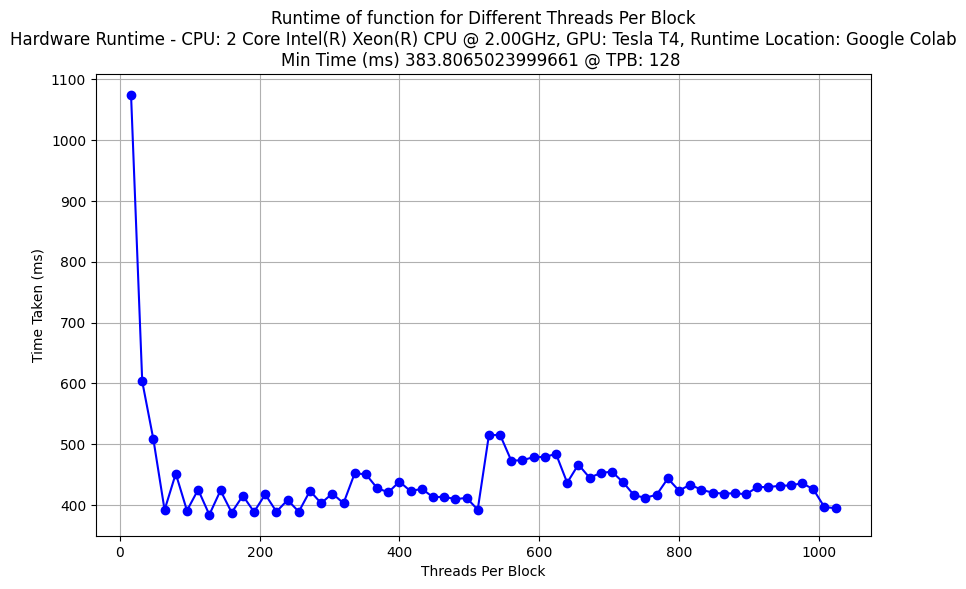

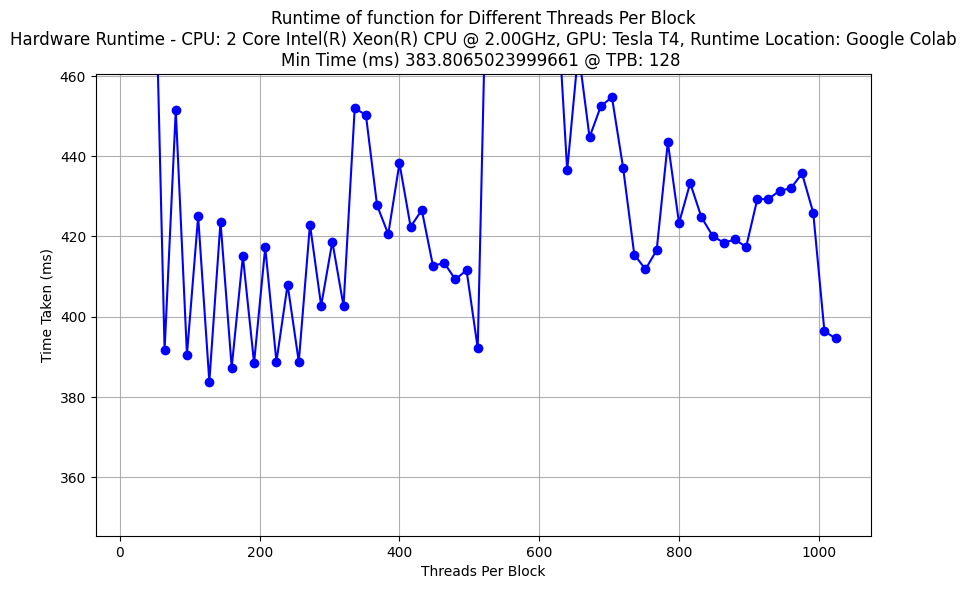

In [ ]:
#|include: false
print(hardware_runtime_info)
plot_timeit_results(results0)
plot_timeit_results(results0,limit_y_axis=True)

![image](https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/benchmark_numba_gpu_0.png)
![image](https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/benchmark_numba_gpu_0_zoom.png)

In [ ]:
#|echo: false
dur_sec_numba_gpu_cuda_float32 = 400/1000
dur_sec = dur_sec_numba_gpu_cuda_float32
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec ,'sec to check the entire dataset')
print(f"{round(dur_sec_pandas_iterrows/dur_sec,0):,}" ,'times speedup vs pandas iterrows')
print(round(dur_sec_numba_cpu_float32/dur_sec,10) ,'times speedup vs numba cpu float32')
print(round(dur_sec_custom_gpu_cuda_kernel_torch_load_inline/dur_sec,10) ,'times speedup vs custom gpu cuda kernel torch load_inline')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
100 % of data checked
0.00011111111111111112 hours to check the entire dataset
0.4 sec to check the entire dataset
7,000,000.0 times speedup vs pandas iterrows
175.0 times speedup vs numba cpu float32
0.9225 times speedup vs custom gpu cuda kernel torch load_inline


### CUDA Kernel Using Shared Memory v1

Next, we'll utilize shared memory to try and speed up our CUDA kernel. Shared memory is ultra-fast memory shared between all threads in a block, and it is approximately 10 times faster than global GPU memory. The Nvidia T4 and RTX 3090 have 48KB of shared memory available per thread block, compared to 16GB and 24GB, respectively, of global memory VRAM in each card.

In our CUDA kernel implementation, each thread computes all comparisons for one element from `set1` against all elements of `set2` by looping over all elements in `set2`. This means that in our original CUDA kernel implementation, each thread has to load all elements of `set2` from global memory. To speed this up, we can break `set2` into chunks so that each chunk fits into shared memory and each element in the chunk can be fetched from global memory only once per block by a single thread.

We'll add another loop to our kernel to loop through each `set2` chunk. In the outer loop, each thread will load a single value of `set2` into shared memory, and then in the inner loop, we'll compare the element from `set1` with each element from `set2` in shared memory. If our kernel is memory-bound, this should speed up our overall runtime.

In [ ]:
def find_overlap_gpu_numba_smem(s1, s2, out, tpb=256, s2cachesize=256):
    dyn_shared_mem_size = s2cachesize * 6 * 4
    blocks = math.ceil(len(s1)/tpb)
    find_overlap_gpu_numba_kernel_smem[blocks, tpb, 0, dyn_shared_mem_size](ca(s1), ca(s2), ca(out), s2cachesize)
    return out.cpu()


In [ ]:
@cuda.jit
def find_overlap_gpu_numba_kernel_smem(s1, s2, out, s2cachesize):
    cbidx, cbdim, tidx = cuda.blockIdx.x,cuda.blockDim.x,cuda.threadIdx.x
    s1idx = cbidx * cbdim + tidx

    s1len = len(s1)
    s2len = len(s2)

    if s1idx < len(s1):
        s10, s11, s12, s13, s14, s15 = s1[s1idx]
    else:
        s10, s11, s12, s13, s14, s15 = np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)
    outidx = 0

    #Allocate our shared memory
    smem = cuda.shared.array(0, dtype=np.float32)

    #Loop through the set2 chunks
    for s2idx_beg in range(0,math.ceil(len(s2)/cbdim)*cbdim,cbdim):

        #Load Shared Memory
        if s2idx_beg+tidx < s2len:
            for i in range(6):
                smem[tidx*6+i] = s2[s2idx_beg+tidx,i]
        #We need to synchronize all the threads across the block to ensure they are all done loading their values into shared memory before we proceed.
        cuda.syncthreads()

        if s1idx < len(s1):
            #Loop through all items that were loaded into shared memory
            for s2idx_global in range(s2idx_beg, min(s2idx_beg+cbdim,s2len)):
                s2idx_local = (s2idx_global - s2idx_beg)*6
                s2l = smem[s2idx_local:s2idx_local+6]
                if s10 <= s2l[3] and s11 <= s2l[4] and s12 <= s2l[5] and \
                    s13 >= s2l[0] and s14 >= s2l[1] and s15 >= s2l[2]:
                    if outidx < 6:
                        out[s1idx,outidx] = s2idx_global
                        outidx += 1
            if outidx == 6:
                out[s1idx,5] = -2
        # We again need to sync threads because all threads must be done doing
        # their checks prior to loading the next set2 chunk
        cuda.syncthreads()

In [ ]:
#|output: false
out = init_out()
print(hardware_runtime_info)
%timeit -n 10 find_overlap_gpu_numba_smem(set1_tt, set2_tt, out, tpb=512, s2cachesize=512)
assert torch.all(out==output_test_tt.cuda())
out

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
345 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
129 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|output: false
print(hardware_runtime_info)
out = init_out()
n = 20
%timeit -n 10 find_overlap_gpu_numba_smem(set1_tt, set2_tt, out, tpb=n*32, s2cachesize=n*32)
assert torch.all(out==output_test_tt.cuda())
out

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
399 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
114 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|output: false
print(hardware_runtime_info)
out = init_out()
n = 32
%timeit -n 10 find_overlap_gpu_numba_smem(set1_tt, set2_tt, out, tpb=n*32, s2cachesize=n*32)
assert torch.all(out==output_test_tt.cuda())
out

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
338 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
122 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|output: false
results1 = []
print(hardware_runtime_info)
for n in tqdm(range(1,64+1)):
  out = init_out()
  timeit_results = %timeit -o -q -r 1 -n 10 find_overlap_gpu_numba_smem(set1_tt, set2_tt, out, tpb=n*16, s2cachesize=n*16)
  assert torch.all(out==output_test_tt.cuda())
  # print(n,timeit_results)
  results1.append({'timeit_results':timeit_results, 'threads_per_block':n*16})

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


  0%|          | 0/64 [00:00<?, ?it/s]

```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
100% XXXXXXXXXXXXXXXXXXXXXX 64/64 [04:09<00:00,  3.55s/it]
```

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


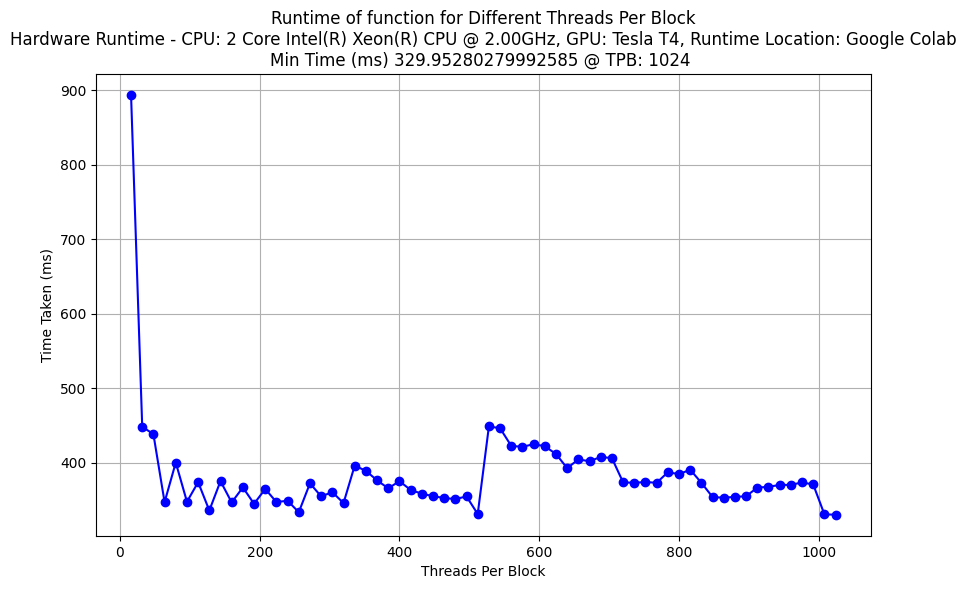

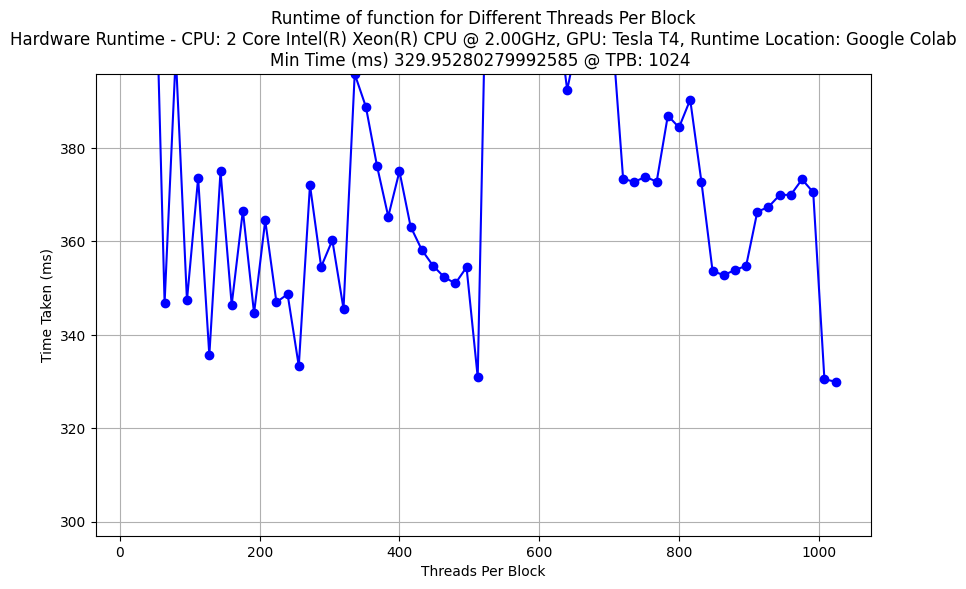

In [ ]:
#|include: false
print(hardware_runtime_info)
plot_timeit_results(results1)
plot_timeit_results(results1, limit_y_axis=True)

![image](https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/benchmark_numba_gpu_smem_1.png)
![image](https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/benchmark_numba_gpu_smem_1_zoom.png)

In [ ]:
#|echo: false
dur_sec_numba_gpu_cuda_smem1_tpb_1024 = 333/1000
dur_sec = dur_sec_numba_gpu_cuda_smem1_tpb_1024
print('Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab')
print(100,'% of data checked')
print(dur_sec / 60 / 60,'hours to check the entire dataset')
print(dur_sec ,'sec to check the entire dataset')
print(f"{round(dur_sec_pandas_iterrows/dur_sec,0):,}" ,'times speedup vs pandas iterrows')
print(round(dur_sec_custom_gpu_cuda_kernel_torch_load_inline/dur_sec,10) ,'times speedup vs custom gpu cuda kernel torch load_inline')
print(round(dur_sec_numba_gpu_cuda_float32/dur_sec,10) ,'times speedup vs numba gpu cuda kernel float32')

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
100 % of data checked
9.25e-05 hours to check the entire dataset
0.333 sec to check the entire dataset
8,408,408.0 times speedup vs pandas iterrows
1.1081081081 times speedup vs custom gpu cuda kernel torch load_inline
1.2012012012 times speedup vs numba gpu cuda kernel float32


As you can see using shared memory gave us a nice 20% speed improvement over our previous numba kernel that did not utilize shared memory.

### CUDA Kernel Using Shared Memory v2

Next we'll try a slight variation where we test if loading multiple set2 elements into shared memory per thread is faster (`cache_items_per_thread`) than only loading a single element per thread as in our v1 example.

In [ ]:
@cuda.jit
def find_overlap_gpu_numba_kernel_smem(s1, s2, out, cache_items_per_thread):
    cbidx, cbdim, tidx = cuda.blockIdx.x,cuda.blockDim.x,cuda.threadIdx.x
    s1idx = cbidx * cbdim + tidx

    s1len = len(s1)
    s2len = len(s2)

    zf = np.float32(0.0)

    if s1idx < len(s1):
        s10, s11, s12, s13, s14, s15 = s1[s1idx]
    else:
        s10, s11, s12, s13, s14, s15 = zf, zf, zf, zf, zf, zf
    outidx = 0

    smem = cuda.shared.array(0, dtype=np.float32)
    for s2idx_beg in range(0,math.ceil(len(s2)/(cbdim*cache_items_per_thread))*cbdim*cache_items_per_thread+1,
                           cbdim*cache_items_per_thread):

        #Load Shared Memory
        if s2idx_beg+tidx < s2len:
            #Loop through the number of cache_items_per_thread - This is the main difference
            #with our v1 implementation where we always loaded 1 item per thread.
            for i in range(cache_items_per_thread):
                if s2idx_beg+tidx*cache_items_per_thread+i < s2len:
                    for j in range(6):
                        smem[(tidx*cache_items_per_thread+i)*6+j] = s2[s2idx_beg+tidx*cache_items_per_thread+i,j]
        cuda.syncthreads()

        if s1idx < len(s1):

            for s2idx_global in range(s2idx_beg, min(s2idx_beg+cbdim*cache_items_per_thread,s2len)):
                s2idx_local = (s2idx_global - s2idx_beg)*6
                s2l = smem[s2idx_local:s2idx_local+6]

                if s10 <= s2l[3] and s11 <= s2l[4] and s12 <= s2l[5] and \
                    s13 >= s2l[0] and s14 >= s2l[1] and s15 >= s2l[2]:

                    if outidx < 6:
                        out[s1idx,outidx] = s2idx_global
                        outidx += 1

        cuda.syncthreads()

In [ ]:
def find_overlap_gpu_numba_smem(s1, s2, out, tpb=256, cache_items_per_thread=1):
    dyn_shared_mem_size = (tpb*cache_items_per_thread) * 6 * 4
    blocks = math.ceil(len(s1)/tpb)
    find_overlap_gpu_numba_kernel_smem[blocks, tpb, 0, dyn_shared_mem_size](ca(s1), ca(s2), ca(out), cache_items_per_thread)
    return out.cpu()

First we'll test it out to make sure it works and produces the correct result.

In [ ]:
#|output: false
out = init_out()
print(hardware_runtime_info)
%timeit -n 10 find_overlap_gpu_numba_smem(set1_tt, set2_tt, out, tpb=39*16, cache_items_per_thread=3)
assert torch.all(out==output_test_tt.cuda())
out

Benchmark Results:
```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: Tesla T4, Runtime Location: Google Colab
417 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)
----------------------------------------------------------------------------------------------------
Hardware Runtime - CPU: 12 Core Intel(R) Xeon(R) CPU @ 2.20GHz, GPU: NVIDIA A100-SXM4-40GB, Runtime Location: Google Colab
152 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
----------------------------------------------------------------------------------------------------
```

In [ ]:
#|output: false
print(hardware_runtime_info)
results2 = []
best_result = None
for tpbn in tqdm(range(4,64+1)): #Lower than 4 takes forever and is not fastest
    for ciptn in tqdm(range(1,2048//(tpbn*16)+1)):
        out = init_out()
        #verify this is less than the shared memory size
        if tpbn*16 * ciptn > 2048:
            pass
        else:
            timeit_results = %timeit -o -q -r 1 -n 10 find_overlap_gpu_numba_smem(set1_tt, set2_tt, out, tpb=tpbn*16, cache_items_per_thread=ciptn)
            assert torch.all(out==output_test_tt.cuda())
            if best_result is None or timeit_results.average < best_result.average:
                best_result = timeit_results
                print(tpbn*16,ciptn,timeit_results)
            results2.append({'timeit_results':timeit_results, 'threads_per_block':tpbn*16, 'cache_items_per_thread':ciptn})

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

64 1 427 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
64 2 352 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

96 1 350 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

128 1 337 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

256 1 335 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

512 1 331 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

1008 1 330 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


  0%|          | 0/2 [00:00<?, ?it/s]

1024 1 329 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
100% 61/61 [38:27<00:00,  7.17s/it]
100% 32/32 [07:05<00:00, 23.28s/it]
64 1 361 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
64 2 353 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
100% 25/25 [04:32<00:00, 18.24s/it]
100% 21/21 [03:18<00:00, 15.38s/it]
100% 18/18 [02:31<00:00, 13.07s/it]
100% 16/16 [02:04<00:00, 11.74s/it]
128 1 343 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
100% 14/14 [01:41<00:00, 10.31s/it]
100% 12/12 [01:17<00:00,  9.04s/it]
100% 11/11 [01:09<00:00,  8.48s/it]
100% 10/10 [00:57<00:00,  7.53s/it]
100% 9/9 [00:50<00:00,  7.15s/it]
100% 9/9 [00:47<00:00,  6.76s/it]
100% 8/8 [00:42<00:00,  6.49s/it]
100% 8/8 [00:40<00:00,  6.18s/it]
256 1 339 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
100% 7/7 [00:34<00:00,  5.68s/it]
100% 7/7 [00:35<00:00,  5.81s/it]
100% 6/6 [00:28<00:00,  5.36s/it]
100% 6/6 [00:27<00:00,  5.11s/it]
100% 6/6 [00:27<00:00,  5.07s/it]
100% 5/5 [00:23<00:00,  5.07s/it]
100% 5/5 [00:22<00:00,  4.87s/it]
100% 5/5 [00:21<00:00,  4.76s/it]
100% 5/5 [00:21<00:00,  4.71s/it]
100% 4/4 [00:16<00:00,  4.24s/it]
100% 4/4 [00:16<00:00,  4.23s/it]
100% 4/4 [00:15<00:00,  4.15s/it]
100% 4/4 [00:16<00:00,  4.37s/it]
100% 4/4 [00:16<00:00,  4.34s/it]
100% 4/4 [00:16<00:00,  4.37s/it]
100% 4/4 [00:15<00:00,  4.10s/it]
512 1 335 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
100% 3/3 [00:13<00:00,  4.50s/it]
100% 3/3 [00:13<00:00,  4.47s/it]
100% 3/3 [00:12<00:00,  4.24s/it]
100% 3/3 [00:12<00:00,  4.23s/it]
100% 3/3 [00:12<00:00,  4.25s/it]
100% 3/3 [00:12<00:00,  4.24s/it]
100% 3/3 [00:12<00:00,  4.12s/it]
100% 3/3 [00:11<00:00,  3.94s/it]
100% 3/3 [00:12<00:00,  4.06s/it]
100% 3/3 [00:12<00:00,  4.04s/it]
100% 2/2 [00:08<00:00,  4.08s/it]
100% 2/2 [00:08<00:00,  4.05s/it]
100% 2/2 [00:07<00:00,  3.76s/it]
100% 2/2 [00:07<00:00,  3.75s/it]
100% 2/2 [00:07<00:00,  3.80s/it]
100% 2/2 [00:07<00:00,  3.82s/it]
100% 2/2 [00:07<00:00,  3.90s/it]
```

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
best result 329 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


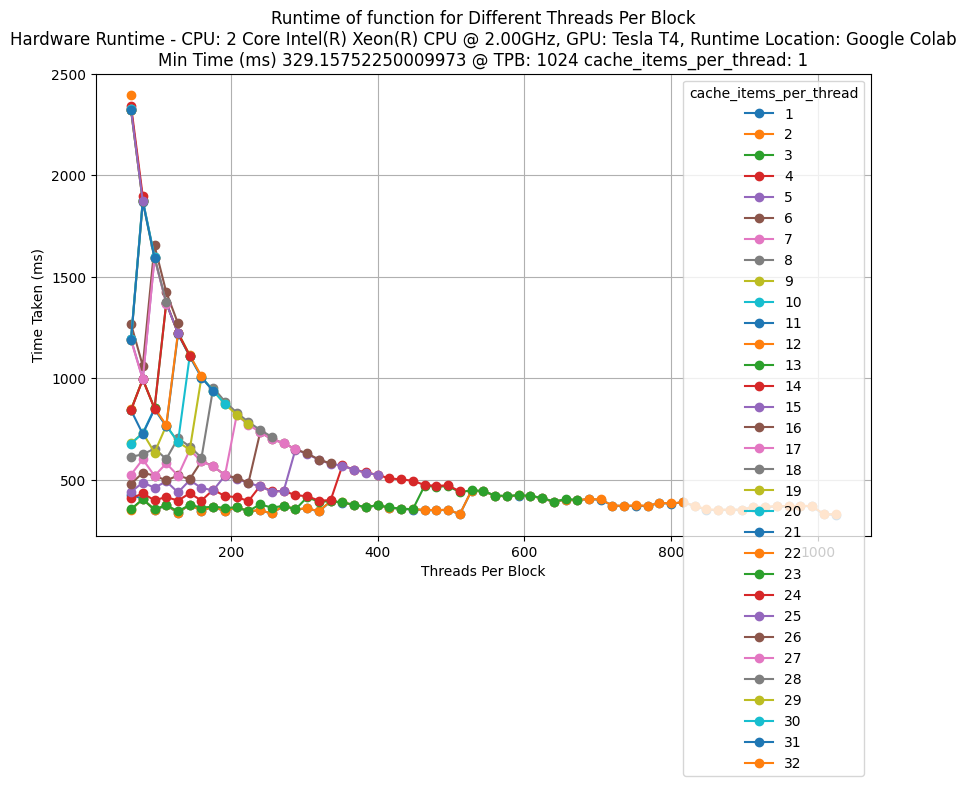

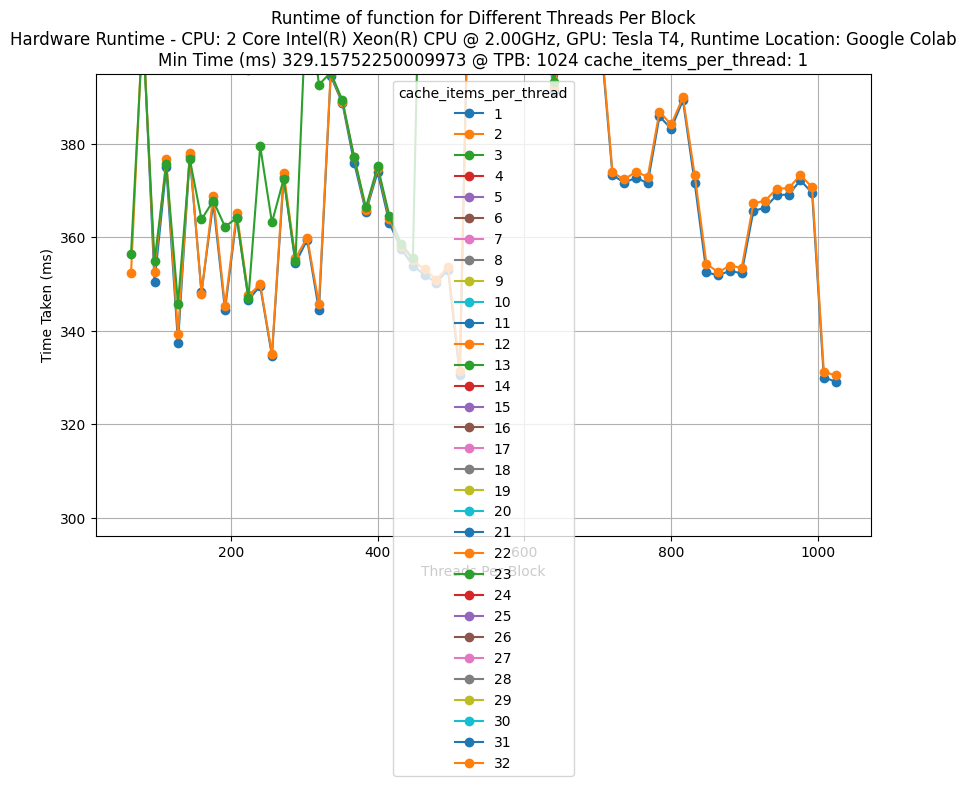

In [ ]:
#|include: false
print(hardware_runtime_info)
print('best result', best_result)
plot_timeit_results(results2, series_key='cache_items_per_thread')
plot_timeit_results(results2, limit_y_axis=True, series_key='cache_items_per_thread')

```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
best result 333 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
```
![image](https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/benchmark_numba_gpu_smem_2.png)
![image](https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/benchmark_numba_gpu_smem_2_zoom.png)

As you can see there are a few results that are very close but the best one was where there was 1 cache item per thread which is effectively the same as our v1 algorithm.

### CUDA Kernel Using Shared Memory v3 **fp16**

Now we'll try the same algorithm but with `fp16` instead of `fp32`, which should cut our memory usage and bandwidth in half. Given the lower precision, we need to carefully check that the results are the same, as we're losing a significant portion (half) of our floating-point resolution.

In [ ]:
@cuda.jit
def find_overlap_gpu_numba_kernel_smem(s1, s2, out, cache_items_per_thread):
    cbidx, cbdim, tidx = cuda.blockIdx.x,cuda.blockDim.x,cuda.threadIdx.x
    s1idx = cbidx * cbdim + tidx

    s1len = len(s1)
    s2len = len(s2)

    zf = np.float16(0.0)

    if s1idx < len(s1):
        s10, s11, s12, s13, s14, s15 = s1[s1idx]
    else:
        s10, s11, s12, s13, s14, s15 = zf, zf, zf, zf, zf, zf
    outidx = 0

    s2_chunk_size = min(cbdim*cache_items_per_thread,4096)

    smem = cuda.shared.array(0, dtype=np.float16)
    for s2idx_beg in range(0,math.ceil(len(s2)/s2_chunk_size)*s2_chunk_size+1,
                           s2_chunk_size):

        #Load Shared Memory
        if s2idx_beg+tidx < s2len and tidx*cache_items_per_thread < s2_chunk_size:
            for i in range(cache_items_per_thread):
                if s2idx_beg+tidx*cache_items_per_thread+i < s2len and tidx*cache_items_per_thread+i < s2_chunk_size:
                    for j in range(6):
                        # smem_idx = (tidx*cache_items_per_thread+i)*6+j
                        # s2idx_x = s2idx_beg+tidx*cache_items_per_thread+i
                        # smem[smem_idx] = s2[s2idx_x,j]
                        smem[(tidx*cache_items_per_thread+i)*6+j] = s2[s2idx_beg+tidx*cache_items_per_thread+i,j]
        cuda.syncthreads()
        # print('start read')
        if s1idx < len(s1):

            for s2idx_global in range(s2idx_beg, min(s2idx_beg+s2_chunk_size,s2len)):
                s2idx_local = (s2idx_global - s2idx_beg)*6
                s2l = smem[s2idx_local:s2idx_local+6]
                if s10 <= s2l[3] and s11 <= s2l[4] and s12 <= s2l[5] and \
                    s13 >= s2l[0] and s14 >= s2l[1] and s15 >= s2l[2]:

                    if outidx < 6:
                        out[s1idx,outidx] = s2idx_global
                        outidx += 1
            # if outidx == 6:
            #     out[s1idx,5] = -2
        cuda.syncthreads()

When declaring the size of the shared memory in this implementation, I initially forgot that it is specified in bytes when the kernel is called. However, when accessed from within the kernel, the bytes per object are taken into account. I was declaring the shared memory size without considering this, which led to continual invalid memory access errors that took quite a while to debug.

In [ ]:
def find_overlap_gpu_numba_smem(s1, s2, out, tpb=256, cache_items_per_thread=1):
    # Note that we change the calculation from .... * 6 * 4 .... to .... * 6 * 2 .... because fp16
    # takes 2 bytes instead of 4 like fp32
    dyn_shared_mem_size = min((tpb*cache_items_per_thread) * 6 * 2, 49152) #48kb of SRAM
    blocks = math.ceil(len(s1)/(tpb))
    find_overlap_gpu_numba_kernel_smem[blocks, tpb, 0, dyn_shared_mem_size](ca(s1), ca(s2), ca(out), cache_items_per_thread)
    return out.cpu()

Now we need to create fp16 torch tensors from our fp32 versions that we were using previously.

In [ ]:
set1_tt_16, set2_tt_16 = set1_tt.to(torch.float16), set2_tt.to(torch.float16)

Now we'll do a quick sanity check to ensure the results are correct.

In [ ]:
#|output: false
print(hardware_runtime_info)
out = init_out()
find_overlap_gpu_numba_smem(set1_tt_16, set2_tt_16, out, tpb=16*16, cache_items_per_thread=1)
print('Output is correct?',torch.all(out==output_test_tt.cuda()))
out

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
Output is correct? tensor(False, device='cuda:0')


tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [ 41295,  41296, 199998, 199999,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)

```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
Output is correct? tensor(False, device='cuda:0')
tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [ 41295,  41296, 199998, 199999,     -1,     -1]], device='cuda:0',
       dtype=torch.int32)
```

As you can see the output is not correct. The question is did we make a mistake in our implementation or is the loss of precision when switching to float16 causing the problem.<br>
<br>
Let's compare the results with our test array `output_test_tt` and see if we initially spot any differences.

In [ ]:
#|output: false
output_test_tt

tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]])

```
tensor([[     0,  35920,     -1,     -1,     -1,     -1],
        [     0,      1,     -1,     -1,     -1,     -1],
        [     1,      2,     -1,     -1,     -1,     -1],
        ...,
        [199996, 199997,     -1,     -1,     -1,     -1],
        [199997, 199998,     -1,     -1,     -1,     -1],
        [199998, 199999,     -1,     -1,     -1,     -1]])
```
As you can see the in last index of set1 the results are different. There are additional matches `41295,  41296`. Let's look at those values.

In [ ]:
#|output: false
set1_tt_16[-1],set2_tt_16[41295],set1_tt[-1],set2_tt[41295]

(tensor([348.5000, 306.7500, 239.3750, 348.5000, 307.0000, 239.5000],
        device='cuda:0', dtype=torch.float16),
 tensor([348.2500, 298.7500, 239.2500, 348.5000, 307.0000, 239.3750],
        device='cuda:0', dtype=torch.float16),
 tensor([348.4000, 306.8360, 239.3870, 348.5600, 306.9960, 239.5470],
        device='cuda:0'),
 tensor([348.2370, 298.6260, 239.2440, 348.3870, 307.0380, 239.3940],
        device='cuda:0'))

As you can see they are different between the float16 and float32 versions:<br>
```
(tensor([348.5000, 306.7500, 239.3750, 348.5000, 307.0000, 239.5000],
        device='cuda:0', dtype=torch.float16),
 tensor([348.2500, 298.7500, 239.2500, 348.5000, 307.0000, 239.3750],
        device='cuda:0', dtype=torch.float16),
 tensor([348.4000, 306.8360, 239.3870, 348.5600, 306.9960, 239.5470],
        device='cuda:0'),
 tensor([348.2370, 298.6260, 239.2440, 348.3870, 307.0380, 239.3940],
        device='cuda:0'))
```
Now let's use the check overlap function we built for the PyTorch GPU vectorize implementation, passing in values from both the `float16` and `float32` inputs to see if it produces different results. The `check_overlap_torch` function takes two 2-dimensional arrays and returns a list of tuples containing the indices of a match. Since we only want to compare the numbers in question, we need to expand the first dimension of our test elements, which we can do by indexing into them with `None`. This converts the 1D vector into a 1x6 array, which is required for this function.

In [ ]:
#|output: false
check_overlap_torch(set1_tt_16[-1][None,],set2_tt_16[41295][None],0)

[(0, 0)]

```
[(0, 0)]
```

In [ ]:
#|output: false
check_overlap_torch(set1_tt[-1][None,],set2_tt[41295][None],0)

[]

```
[]
```

As you can see, there is a match when using the `float16` values but not with the `float32` values. This indicates that `float16` is not suitable for our implementation and this use case. Half precision is very common in deep learning workloads and works fine in most cases, so it's something we should check. Although it is not suitable for our use case because it returns incorrect results, I am curious how it performs compared to the `float32` implementations, so we'll run it anyway to see how it works. This will allow you to compare from a benchmarking perspective, but it's a good lesson that it might not work in all cases and it's important to validate our outputs as we go.<br>
<br>
This will take longer to run, as there are significantly more possible `cache_items_per_thread` to check because each element only takes up half the amount of shared memory, allowing us to effectively have twice as many elements in shared memory.


In [ ]:
#|output: false
print(hardware_runtime_info)
results3 = []
best_result = None
for tpbn in tqdm(range(4,64+1)): #Lower than 4 takes forever and is not fastest
    for ciptn in tqdm(range(1,4096//(tpbn*16)+1)): #cache items per thread
        out = init_out()
        if tpbn*16 * ciptn > 4096:
            pass
        else:
            out = init_out()
            #We are going to run less test per iteration because there are a lot more tests to run
            timeit_results = %timeit -o -q -r 1 -n 5 find_overlap_gpu_numba_smem(set1_tt_16, set2_tt_16, out, tpb=tpbn*16, cache_items_per_thread=ciptn)
            # We need to remove our output check as we know it's not going to be correct, but we want to see how
            # fast this runs compared to our float32 implementation.
            # assert torch.all(out==output_test_tt.cuda())
            if best_result is None or timeit_results.average < best_result.average:
                best_result = timeit_results
                print(tpbn*16,ciptn,timeit_results)
            results3.append({'timeit_results':timeit_results, 'threads_per_block':tpbn*16, 'cache_items_per_thread':ciptn})

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

64 1 341 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
64 2 340 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
64 3 337 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

128 1 331 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
128 3 329 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

256 3 329 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

512 1 327 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

```
Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
100% 61/61 [39:45<00:00,  7.12s/it]
100% 64/64 [07:12<00:00, 12.09s/it]
64 1 377 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
64 2 355 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
64 3 354 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
100% 51/51 [04:44<00:00,  9.63s/it]
100% 42/42 [03:20<00:00,  8.20s/it]
96 1 349 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
96 3 347 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
100% 36/36 [02:33<00:00,  7.05s/it]
100% 32/32 [02:03<00:00,  6.32s/it]
128 1 336 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
128 3 333 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
100% 28/28 [01:42<00:00,  5.65s/it]
100% 25/25 [01:20<00:00,  5.05s/it]
100% 23/23 [01:12<00:00,  4.70s/it]
100% 21/21 [01:01<00:00,  4.32s/it]
100% 19/19 [00:53<00:00,  4.01s/it]
100% 18/18 [00:48<00:00,  3.79s/it]
100% 17/17 [00:44<00:00,  3.61s/it]
100% 16/16 [00:40<00:00,  3.43s/it]
100% 15/15 [00:37<00:00,  3.28s/it]
100% 14/14 [00:33<00:00,  3.12s/it]
100% 13/13 [00:31<00:00,  3.03s/it]
100% 12/12 [00:26<00:00,  2.80s/it]
100% 12/12 [00:27<00:00,  2.74s/it]
100% 11/11 [00:25<00:00,  2.70s/it]
100% 11/11 [00:24<00:00,  2.61s/it]
100% 10/10 [00:21<00:00,  2.45s/it]
100% 10/10 [00:22<00:00,  2.51s/it]
100% 9/9 [00:18<00:00,  2.35s/it]
100% 9/9 [00:18<00:00,  2.33s/it]
100% 9/9 [00:18<00:00,  2.31s/it]
100% 8/8 [00:16<00:00,  2.22s/it]
100% 8/8 [00:16<00:00,  2.21s/it]
100% 8/8 [00:16<00:00,  2.21s/it]
100% 8/8 [00:15<00:00,  2.08s/it]
512 1 331 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
100% 7/7 [00:15<00:00,  2.28s/it]
100% 7/7 [00:15<00:00,  2.27s/it]
100% 7/7 [00:14<00:00,  2.14s/it]
100% 7/7 [00:15<00:00,  2.14s/it]
100% 6/6 [00:12<00:00,  2.14s/it]
100% 6/6 [00:12<00:00,  2.13s/it]
100% 6/6 [00:12<00:00,  2.08s/it]
100% 6/6 [00:11<00:00,  1.99s/it]
100% 6/6 [00:12<00:00,  2.04s/it]
100% 6/6 [00:12<00:00,  2.03s/it]
100% 5/5 [00:10<00:00,  2.04s/it]
100% 5/5 [00:10<00:00,  2.03s/it]
100% 5/5 [00:09<00:00,  1.88s/it]
100% 5/5 [00:09<00:00,  1.87s/it]
100% 5/5 [00:09<00:00,  1.88s/it]
100% 5/5 [00:09<00:00,  1.88s/it]
100% 5/5 [00:09<00:00,  1.95s/it]
100% 5/5 [00:09<00:00,  1.93s/it]
100% 5/5 [00:09<00:00,  1.97s/it]
100% 4/4 [00:07<00:00,  1.88s/it]
100% 4/4 [00:07<00:00,  1.79s/it]
100% 4/4 [00:07<00:00,  1.78s/it]
100% 4/4 [00:07<00:00,  1.79s/it]
100% 4/4 [00:07<00:00,  1.79s/it]
100% 4/4 [00:07<00:00,  1.85s/it]
100% 4/4 [00:07<00:00,  1.85s/it]
100% 4/4 [00:07<00:00,  1.87s/it]
100% 4/4 [00:07<00:00,  1.87s/it]
100% 4/4 [00:07<00:00,  1.90s/it]
100% 4/4 [00:07<00:00,  1.89s/it]
100% 4/4 [00:06<00:00,  1.68s/it]
100% 4/4 [00:06<00:00,  1.68s/it]
```

Hardware Runtime - CPU: 2 Core Intel(R) Xeon(R) CPU @ 2.00GHz, GPU: Tesla T4, Runtime Location: Google Colab
best result 327 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


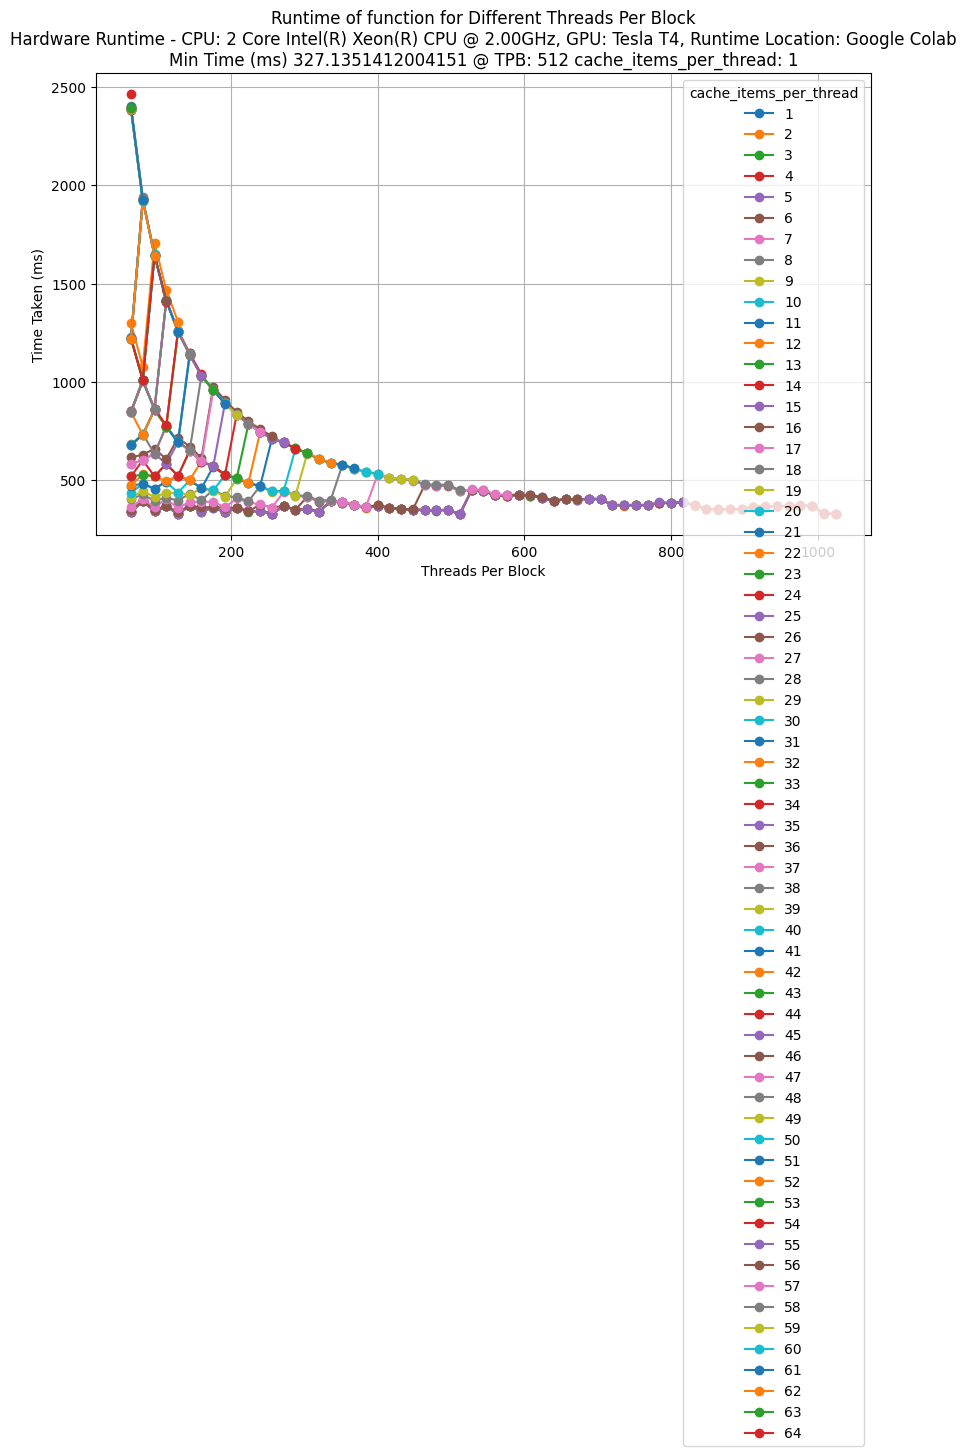

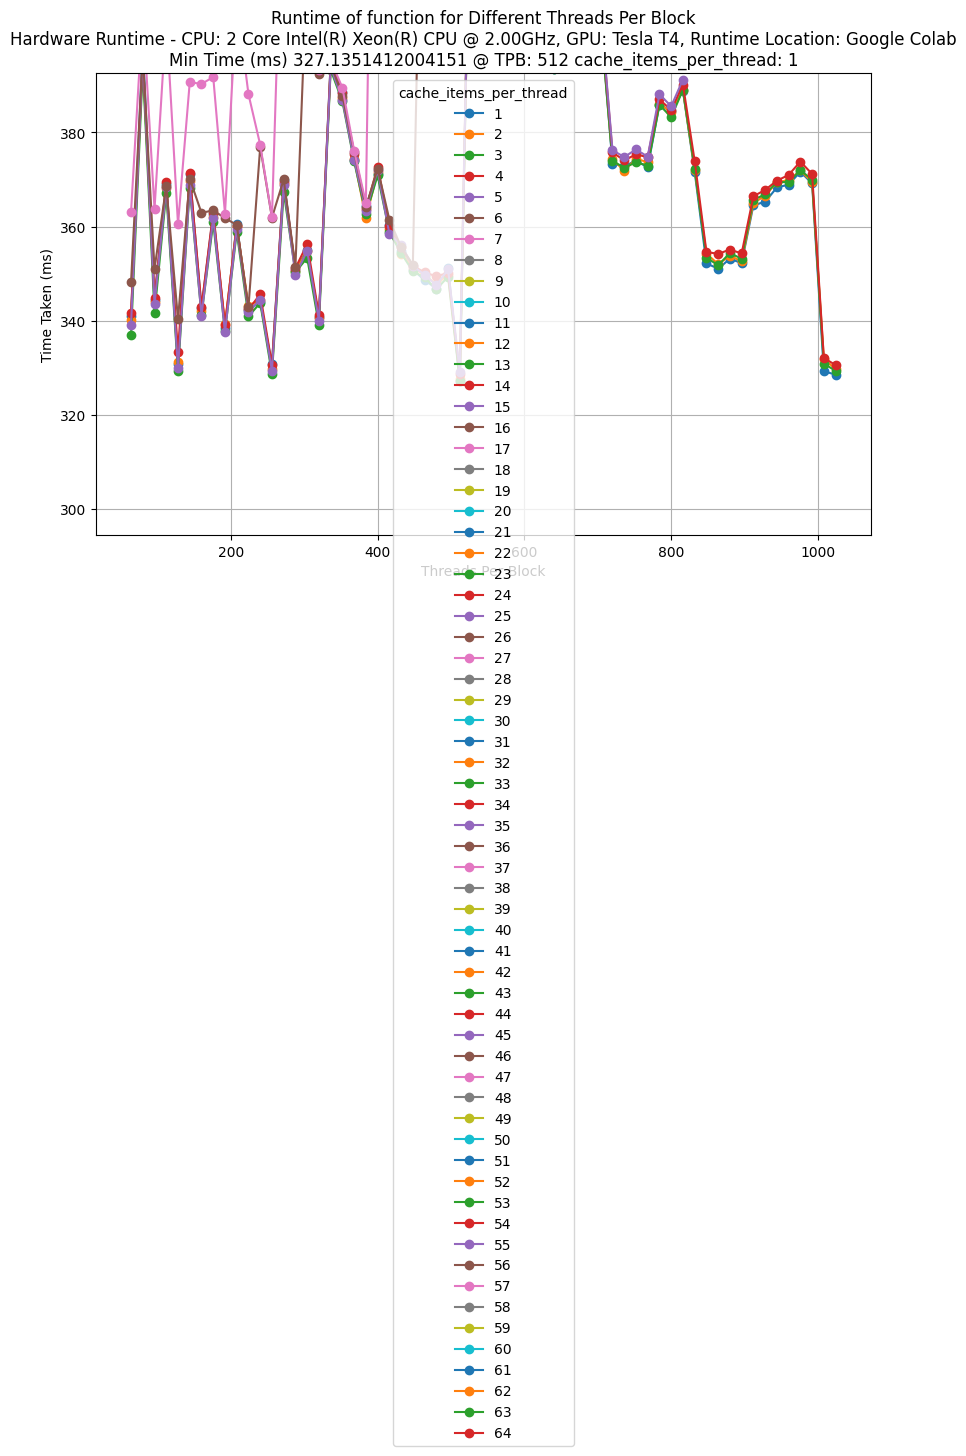

In [ ]:
#|include: false
print(hardware_runtime_info)
print('best result', best_result)
plot_timeit_results(results3, series_key='cache_items_per_thread')
plot_timeit_results(results3, limit_y_axis=True, series_key='cache_items_per_thread')

![image](https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/benchmark_numba_gpu_smem_fp16_3.png)
![image](https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/benchmark_numba_gpu_smem_fp16_3_zoom.png)

Surpringly this kernel is not faster than the float32 kernel. I would have expected this to be a memory bandwidth bound kernel but it does not seem to be.

# Conclusion

In this notebook, we learned how to create CUDA kernels using several different methods, including PyTorch's `load_inline` function to compile a C++ CUDA kernel and Numba's `cuda.jit`. We also created several accelerated CPU implementations. We recorded the execution time for each option using a free Google Colab T4 instance and plotted the results. We achieved an 8.4 million times speedup over our initial pandas implementation. However, even more interesting was the speedup we achieved over the broadcast vectorized examples, which are likely among the fastest common Python implementations. These vectorized operations call highly optimized code, yet we managed to surpass them with our custom kernels.<br>
<br>
The key takeaway from these experiments is that if your use case doesn't quite fit within existing optimized libraries, you can achieve significant speedups with custom CUDA kernels. Additionally, writing basic CUDA kernels is easier than you might have initially thought.


In [ ]:
#|echo: false
from IPython.display import IFrame
IFrame("https://blog.matdmiller.com/posts/2024-02-15_custom_cuda_kernel_intro_and_benchmarks/notebook.html", 100,100)